# Quickstart: オフ方策評価とオフ方策選択 (離散行動空間, 発展的内容)
このノートブックでは簡単な人工データセット上で **オフ方策学習(OPE)とオフ方策選択(OPS)** のより発展的な内容やその活用例を紹介します．

特に、以下の3つの順番で解説していきます: 
1. セットアップ，人工データの生成とオフライン強化学習
2. 様々なオフ方策評価 (方策価値推定，累積分布関数推定)
3. オフ方策選択

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler


# その他のライブラリのインポート
import gym
import torch
from sklearn.model_selection import train_test_split

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データ生成，オフライン強化学習
まず初めに，今回用いる簡単な環境設定について紹介します．

#### 強化学習での環境のセットアップ
今回は簡単なシミュレーション環境上で，方策の獲得する累積報酬を最大化する問題を考えます．

この強化学習の問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 状態観測（POMDPの場合は観測ノイズが発生）．
- `行動`: 強化学習エージェント (方策) により選択された行動．
- `報酬`: 状態と行動に応じて観測される報酬．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart/basic/basic_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env_ja.ipynb).

In [10]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("BasicEnv-discrete-v0")

#### 人工データ生成
オフ方策評価の目標は，過去に集められたデータを用いて新たな方策を評価することです．
そこで次のステップとして、データ収集方策$\pi_0$によりデータセットを収集します（今回はシミュレーション環境をオンライン環境とみなした人工データです）．

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています：
- `env`: 強化学習の（シミュレーション）環境．
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）．

より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart/basic/basic_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection_ja.ipynb).

In [11]:
# データ収集方策
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [13]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [14]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 20:30:43 [warning  ] Parameters will be reinitialized.


In [15]:
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [16]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [18]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [19]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### オフライン強化学習
さて，データ収集が済んだところで，[d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを用いていくつかの"候補"方策を学習します．これは，オフ方策評価では評価対象となる新たな方策に対応します．

オフライン強化学習の手順について詳細に知りたい方は，以下を参照してください[examples/quickstart/basic/basic_synthetic_discrete_basic_ja.ipynb](https://github.com/negocia-inc/scope_rl/blob/ope/examples/quickstart/basic/basic_synthetic_discrete_basic_ja.ipynb).

In [20]:
# モジュールのインポート
from scope_rl.policy import TrainCandidatePolicies
# d3rlpyのモジュールをインポート
from d3rlpy.algos import DiscreteCQLConfig as CQLConfig

In [21]:
# 評価方策
cql_b1 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

cql_b2 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

cql_b3 = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [22]:
# OPLクラスを初期化
opl = TrainCandidatePolicies(
    fitting_args={
        "n_steps": 10000,
    }
)

In [ ]:
# ベースとなる方策を学習
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

In [24]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [25]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [26]:
# 方策のwrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [27]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [28]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. 様々なオフ方策評価
評価対象の方策が学習できたところで，方策の性能指標となる様々な統計量を，オフ方策評価を用いて（オフラインで）推定していきます．

### 準備: OPEのインプットを作成
まず，CreateOPEInputクラスを使いインプットの辞書を作ります．

In [29]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput

In [30]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [32]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [33]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### 標準的な推定

まずはオフ方策評価で一番標準的な，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [34]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [35]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [36]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# 性能推定結果（辞書）
policy_value_df_dict["ddqn_eps_0.3"][0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy      8.534607               1.000000
 dm            81.786347               9.582907
 tis            7.518474               0.880940
 pdis           7.522118               0.881367
 dr             7.764992               0.909824
 sntis          7.543561               0.883879
 snpdis         7.548800               0.884493
 sndr           7.546629               0.884239,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy      6.314321               1.000000
 dm            83.697916              13.255253
 tis            5.496221               0.870437
 pdis           5.504577               0.871761
 dr             6.852540               1.085238
 sntis          5.588000               0.884973
 snpdis         5.597103               0.886414
 sndr           5.565162               0.881356,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy      3.423805           

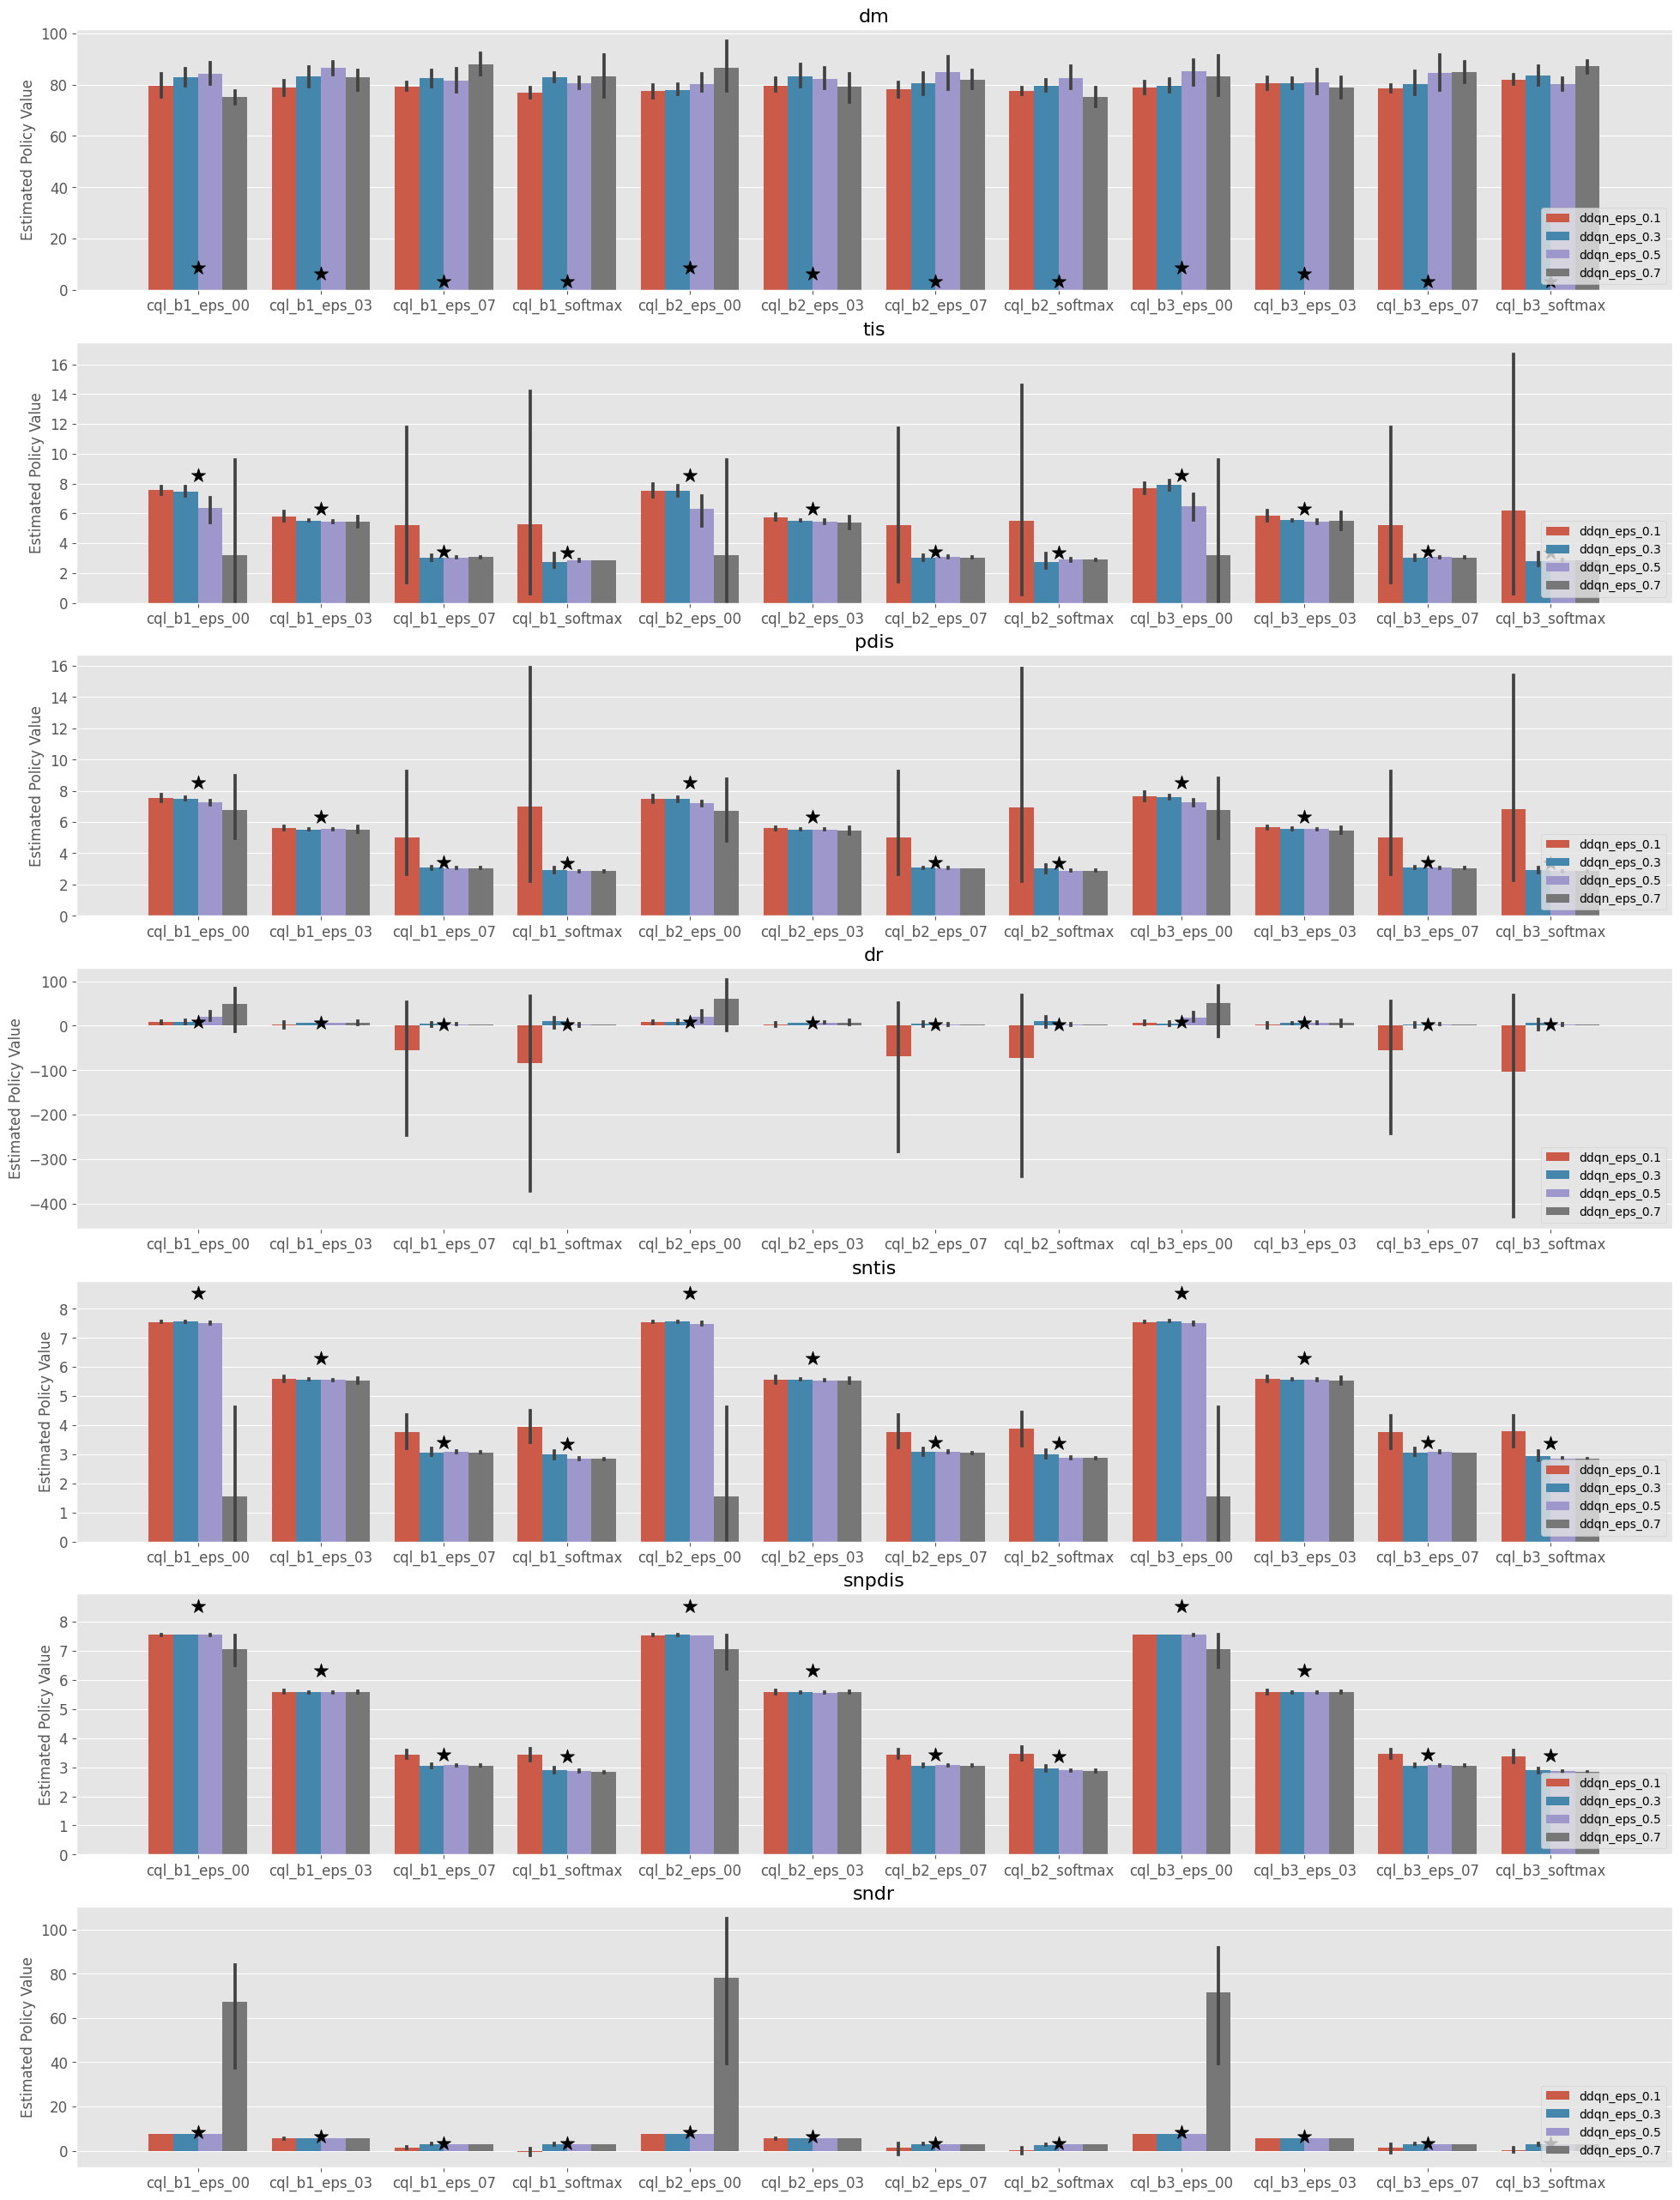

In [37]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

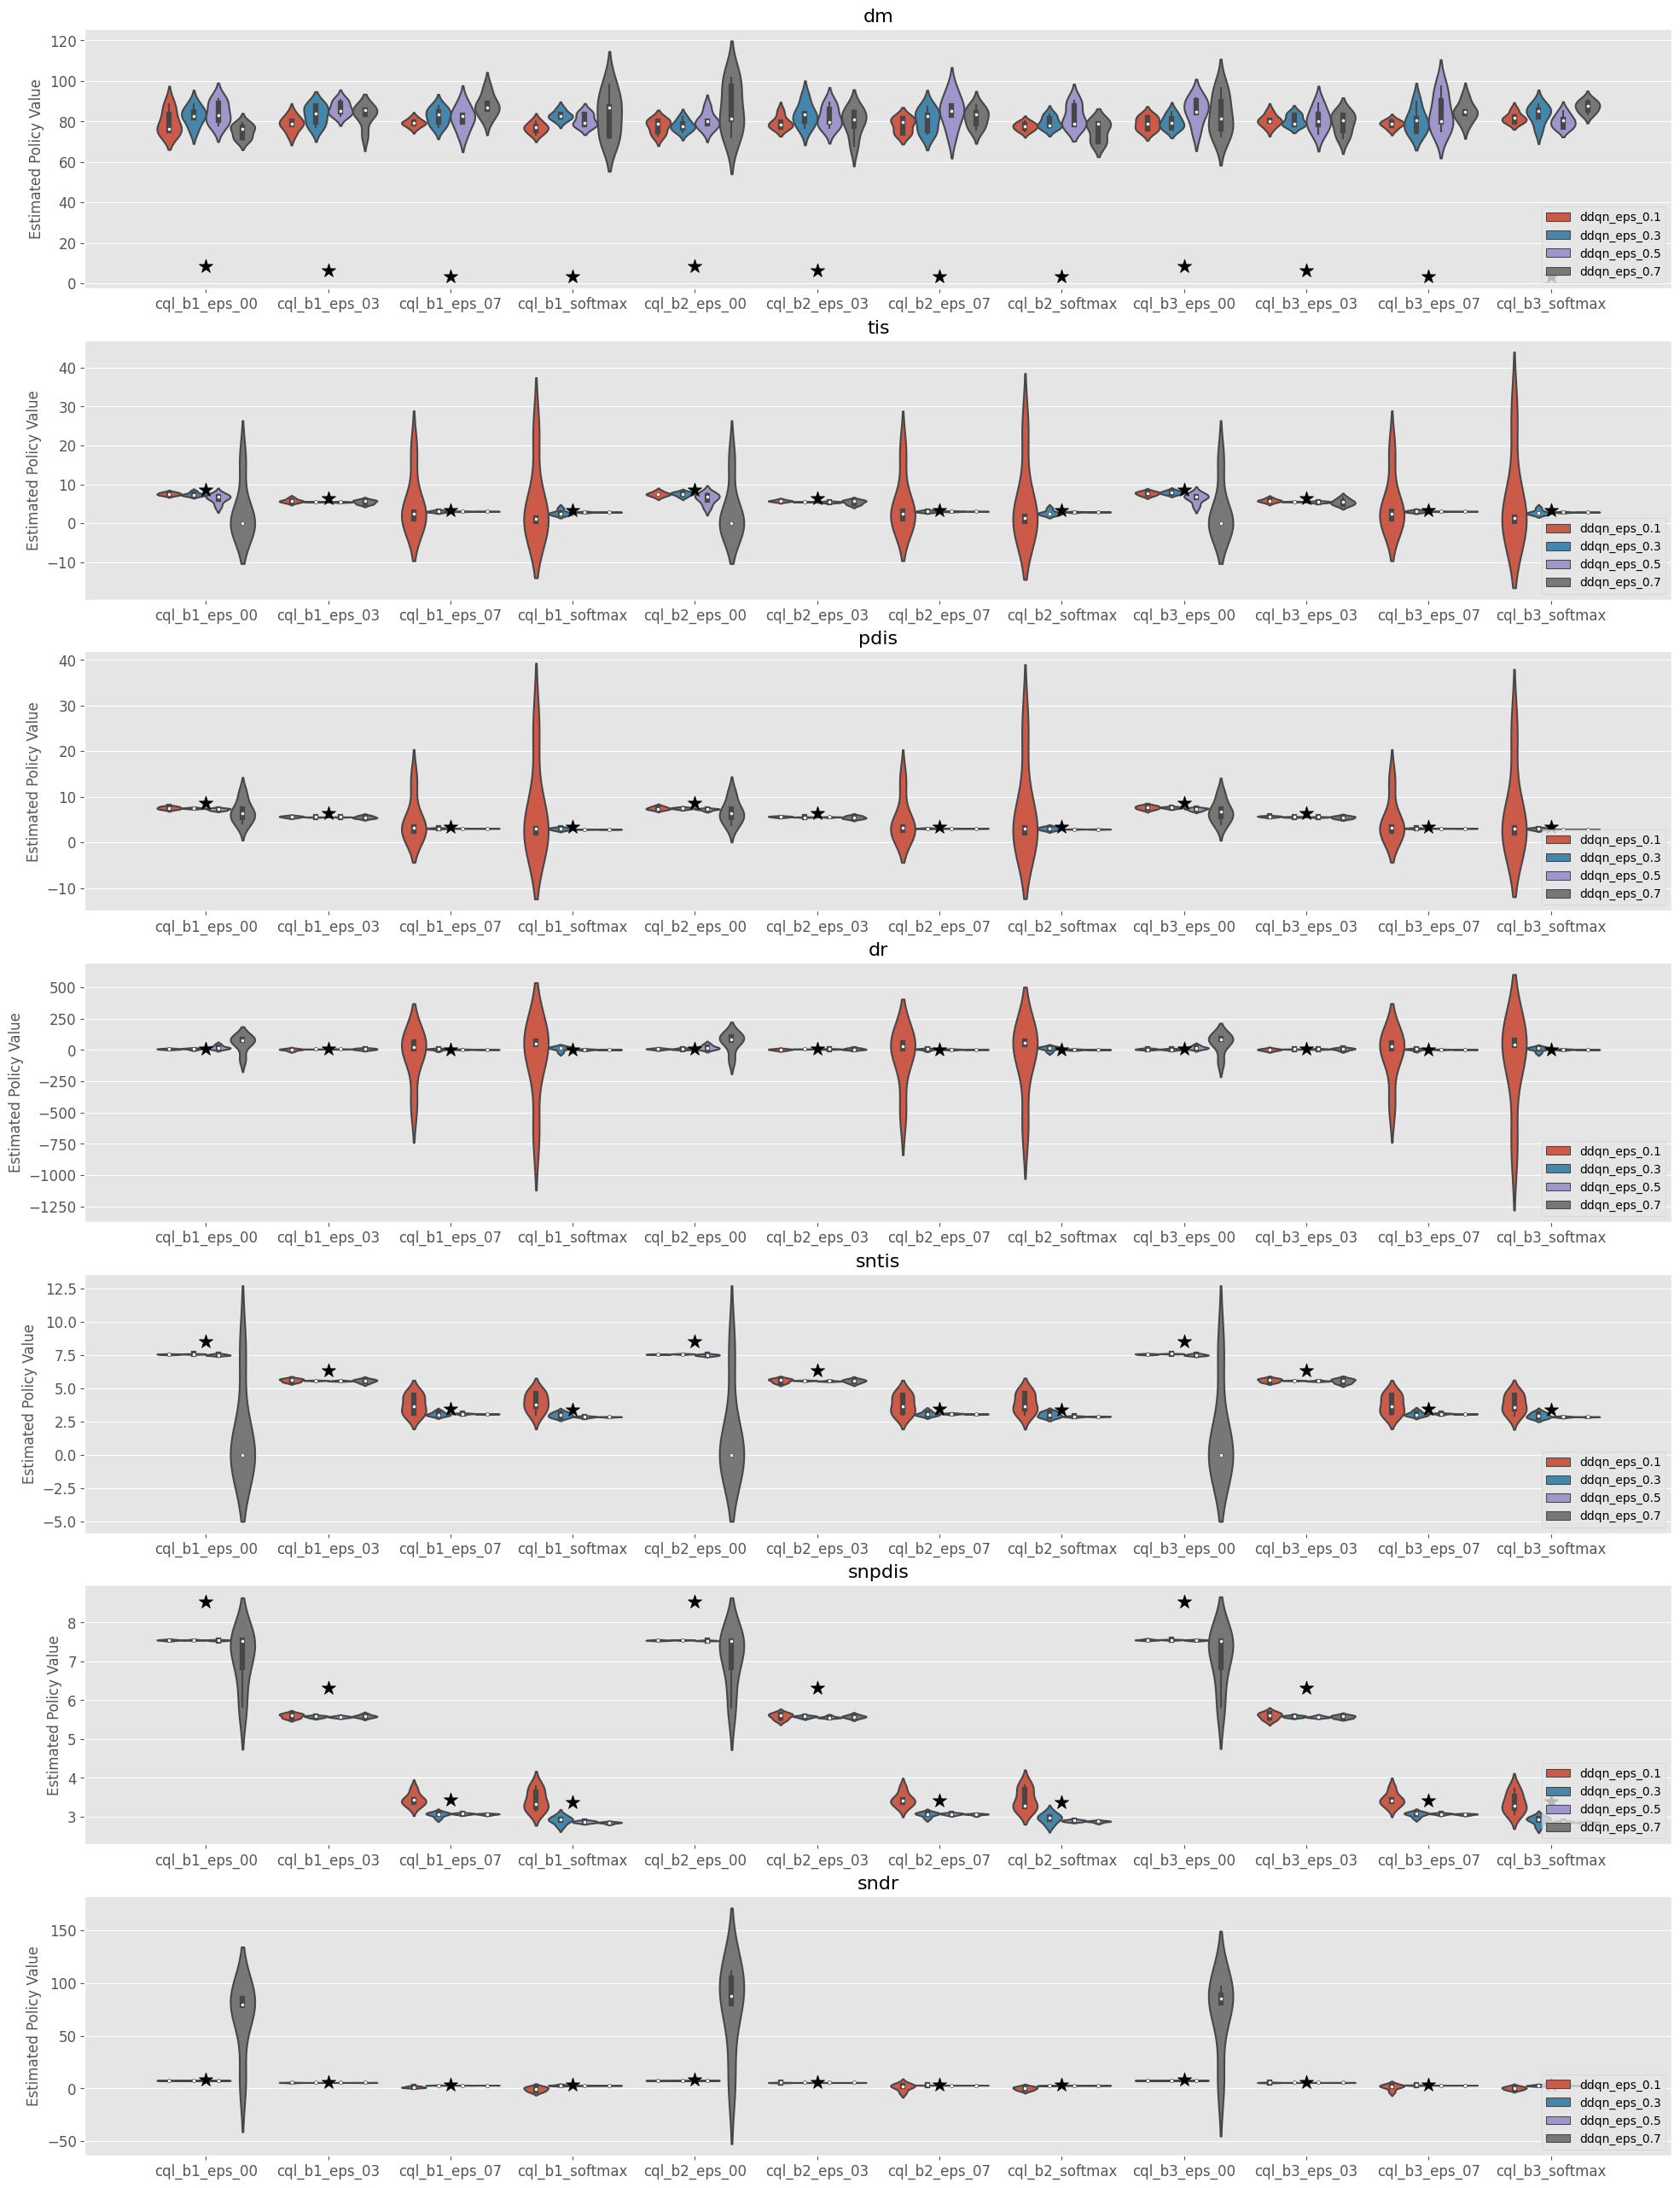

In [38]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

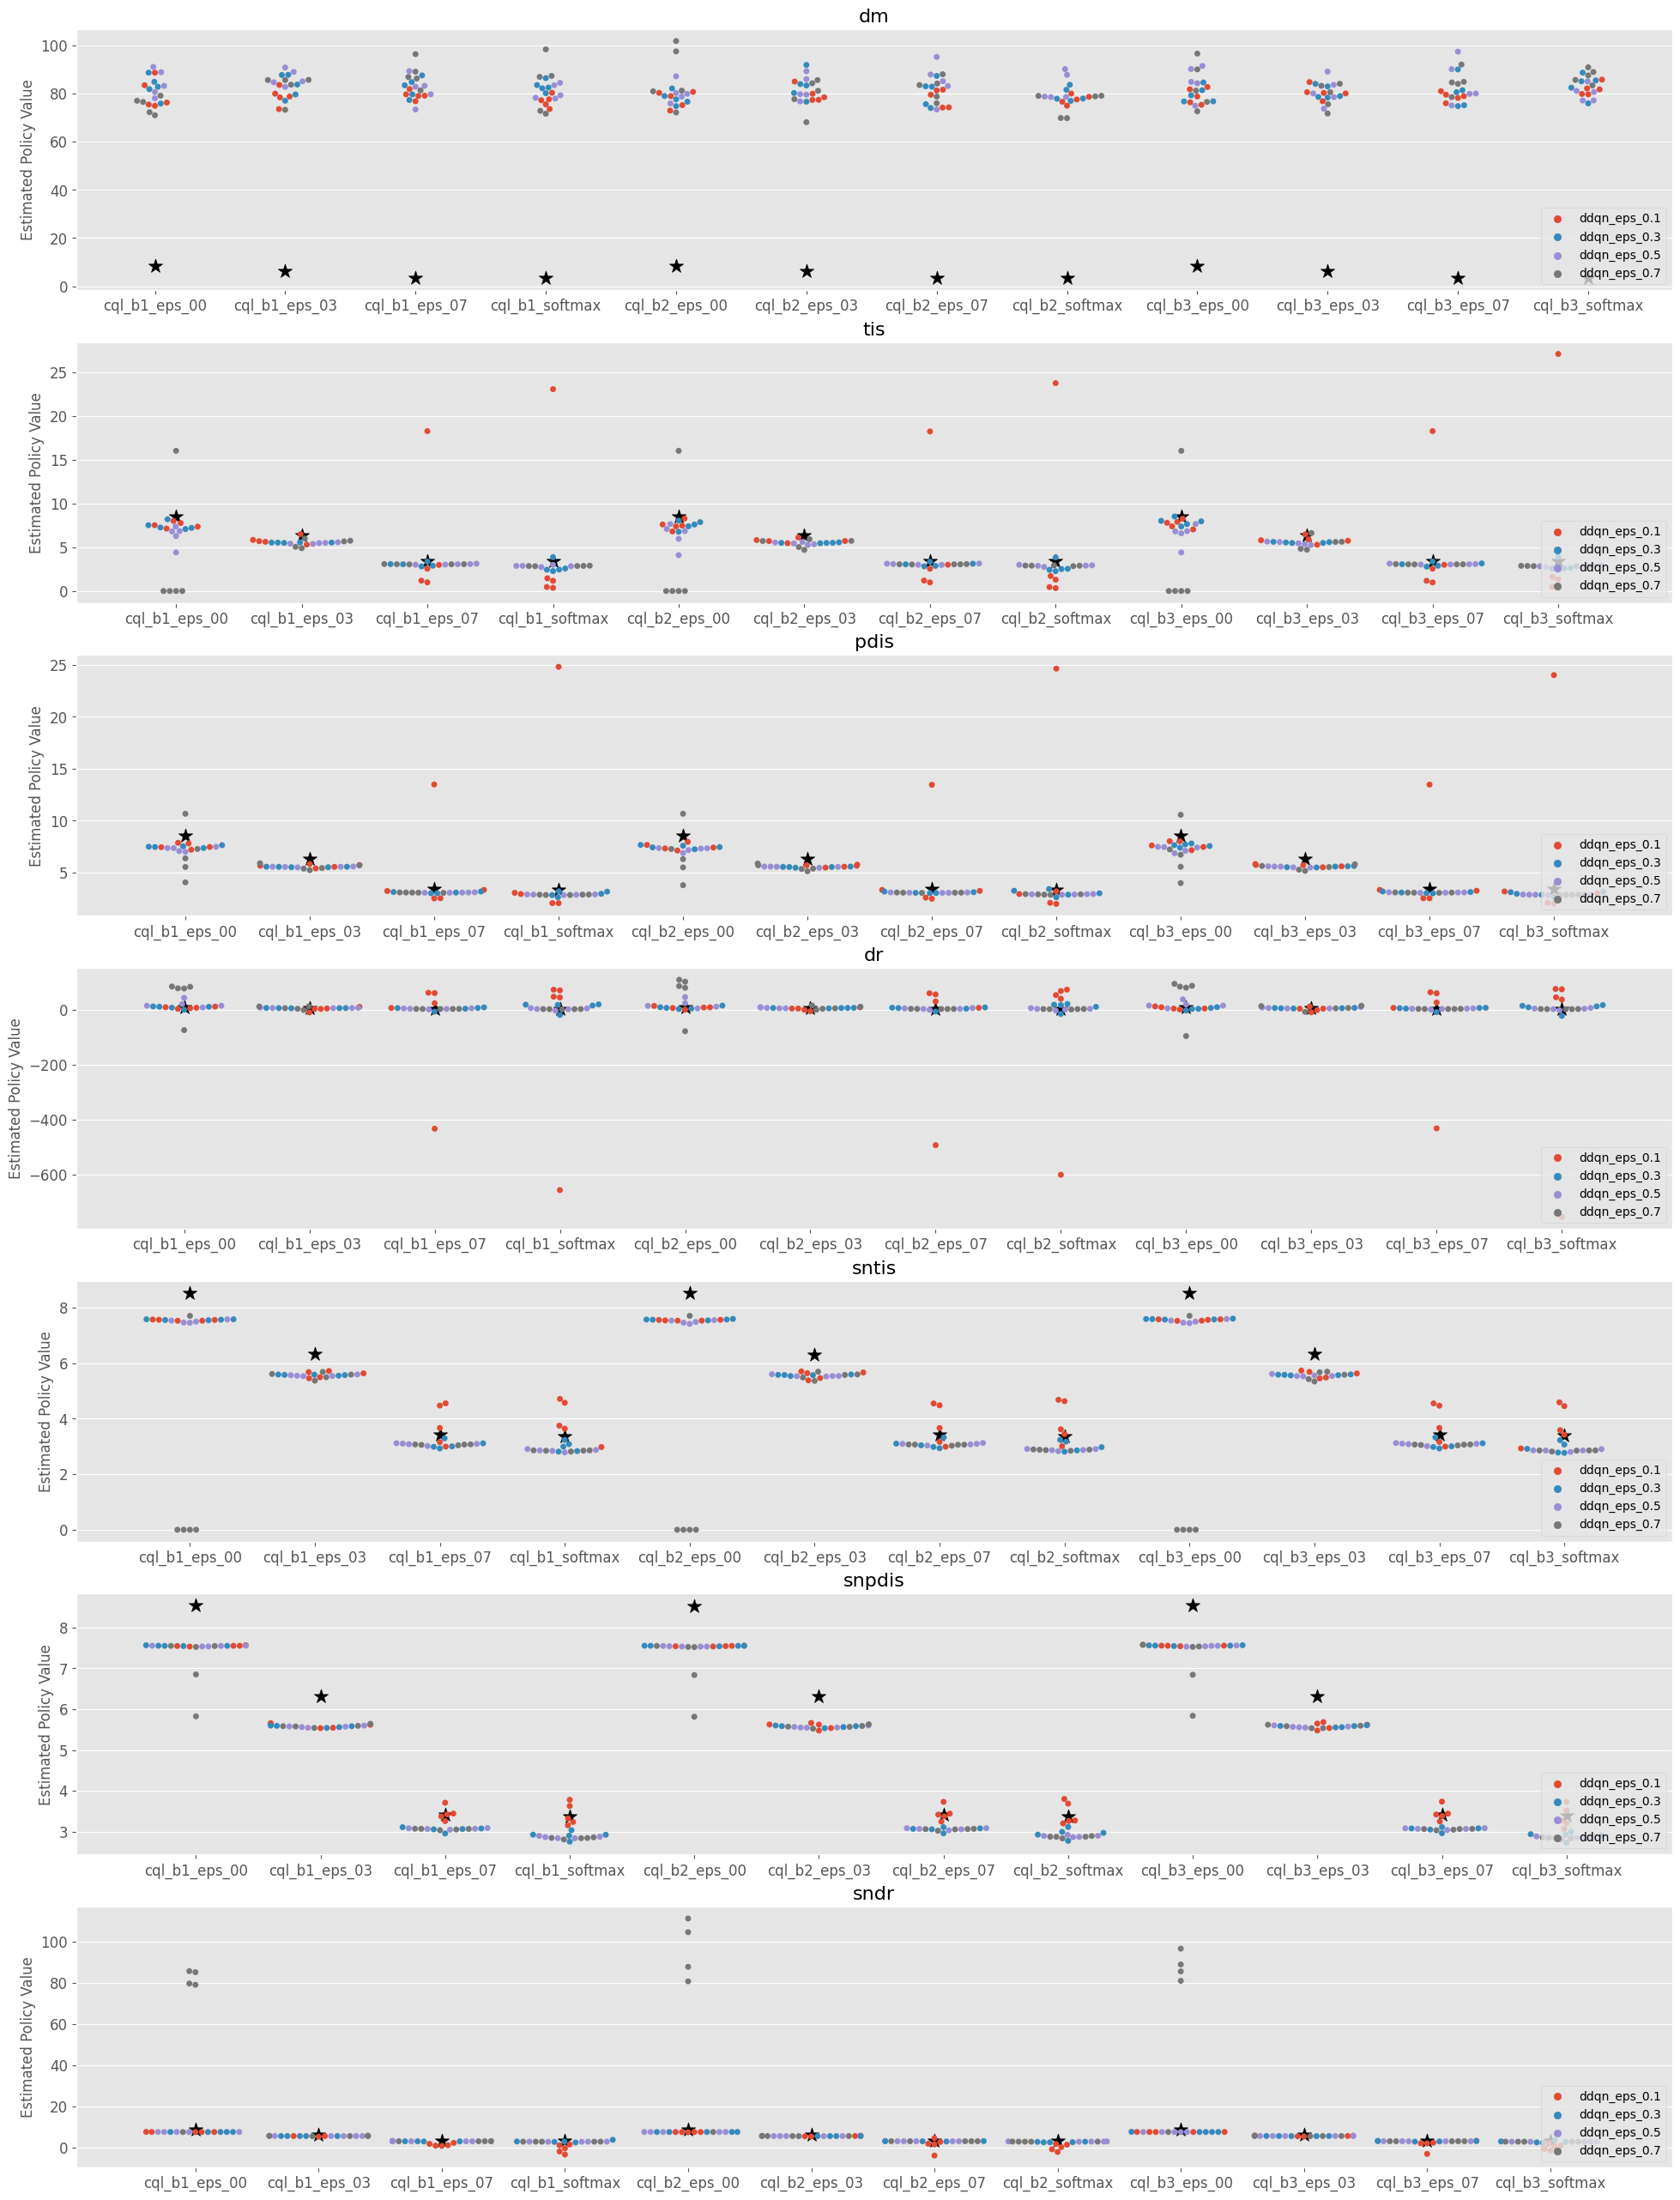

In [39]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### 累積分布関数推定
次に，軌跡単位での報酬の累積分布関数に基づき，方策性能に関する様々な統計量を推定します．

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

特に，上記の累積度数分布から，以下の性能指標を推定することができます．
- 累積分布関数
- 期待値 (方策価値)
- 分散
- CVaR (Conditional Value at Risk)
- 四分位範囲

In [40]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.discrete import CumulativeDistributionDM as CD_DM
from scope_rl.ope.discrete import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.discrete import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.discrete import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.discrete import CumulativeDistributionSNTDR as CD_SNDR

In [41]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

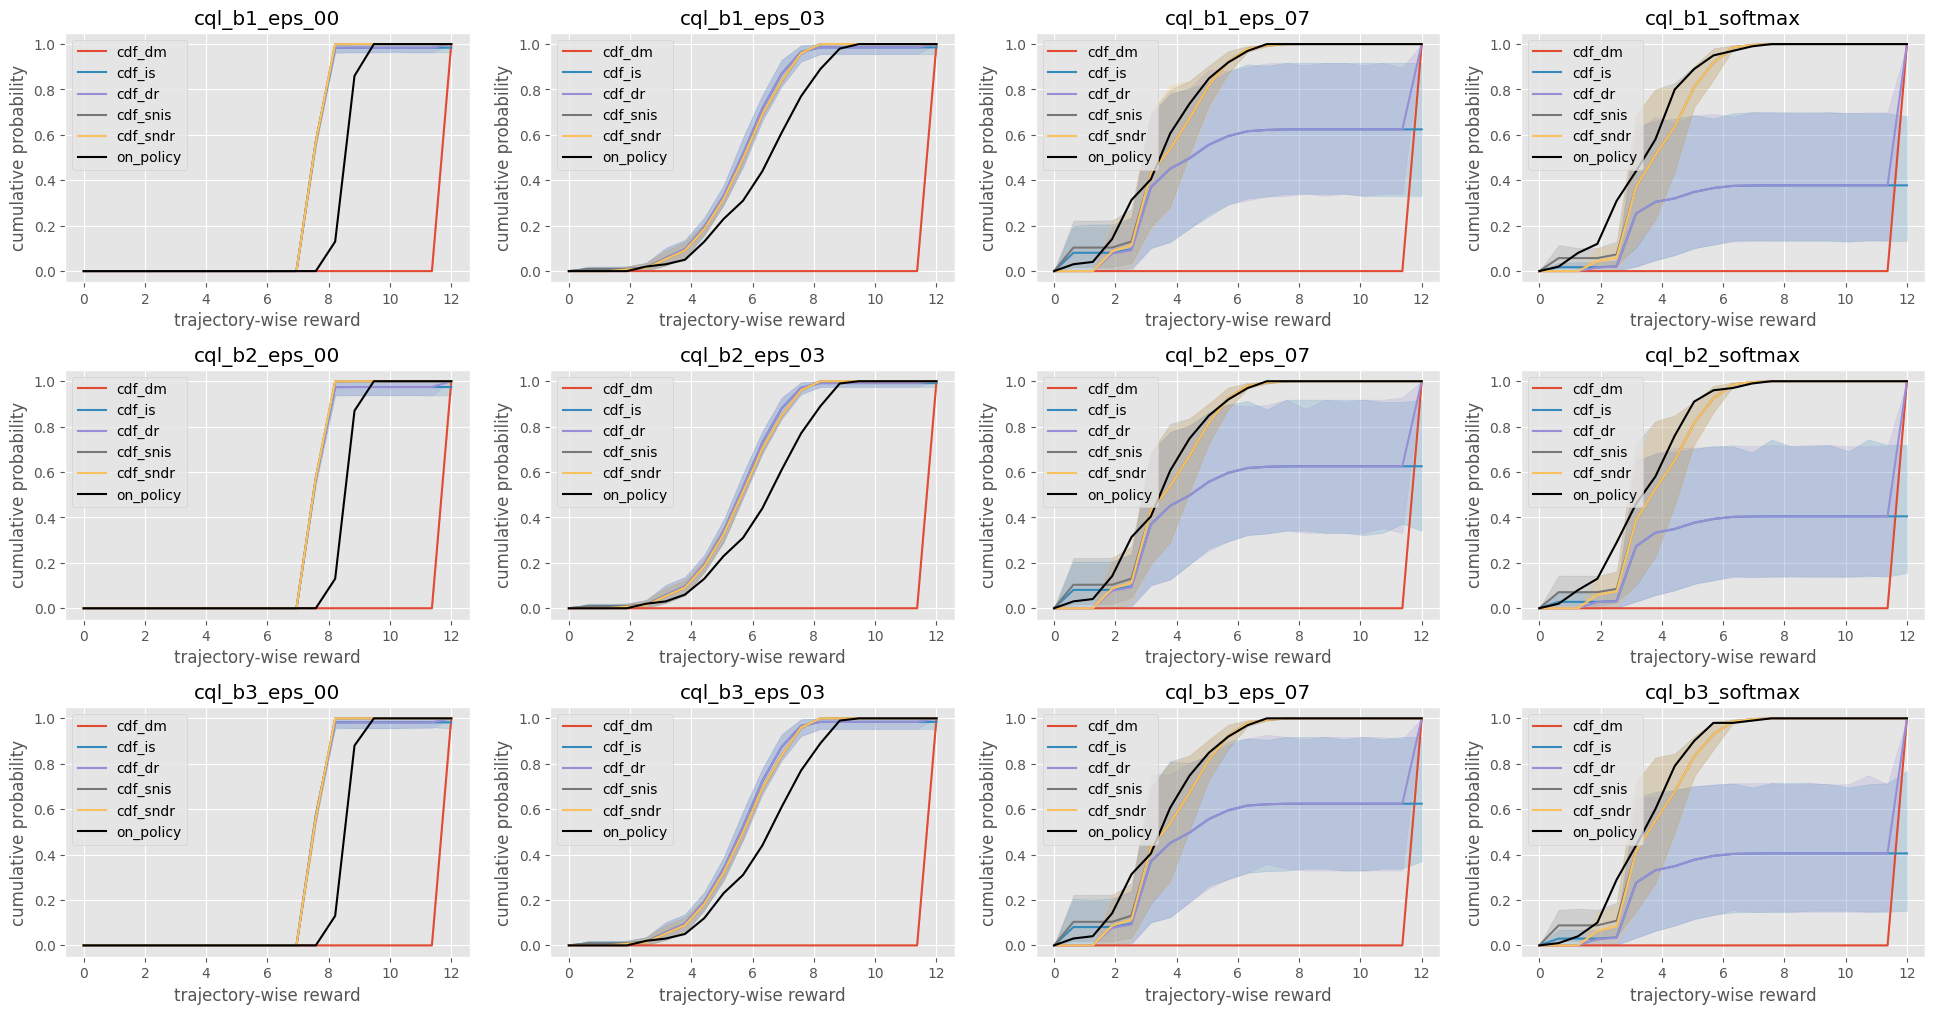

In [42]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
    n_cols=4,
)

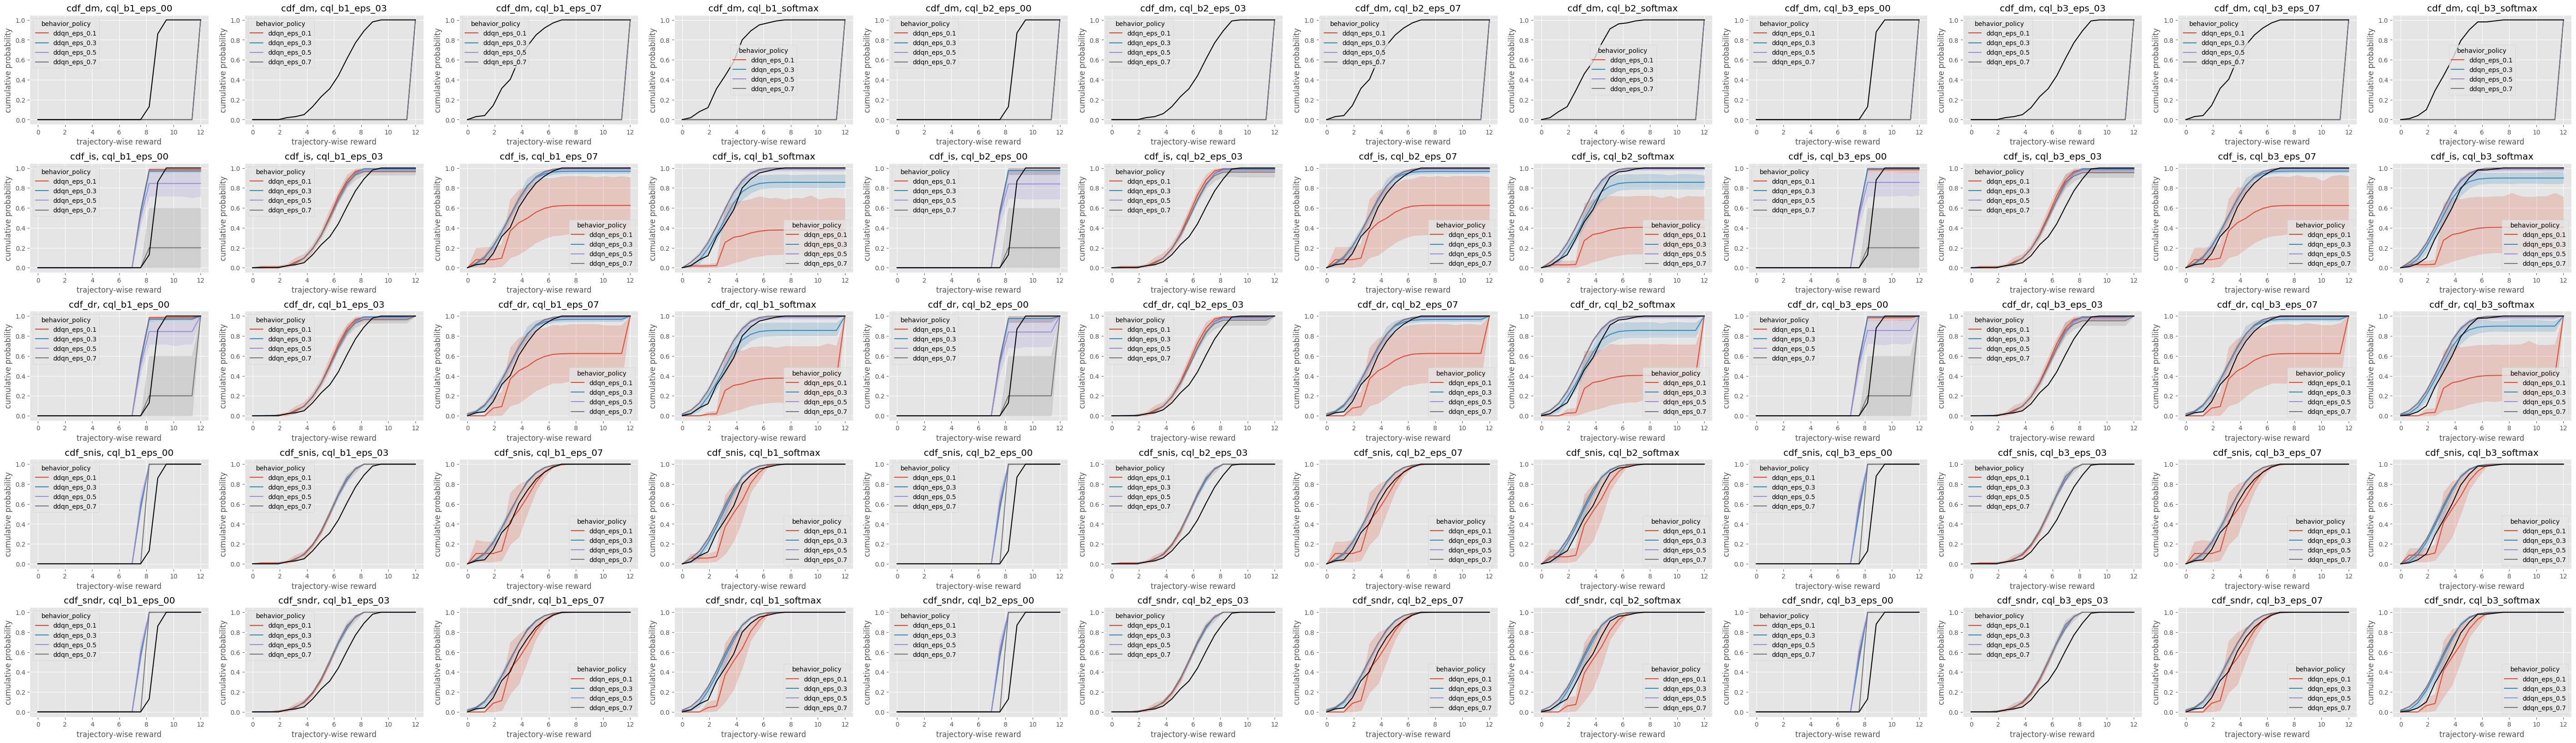

In [43]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
)

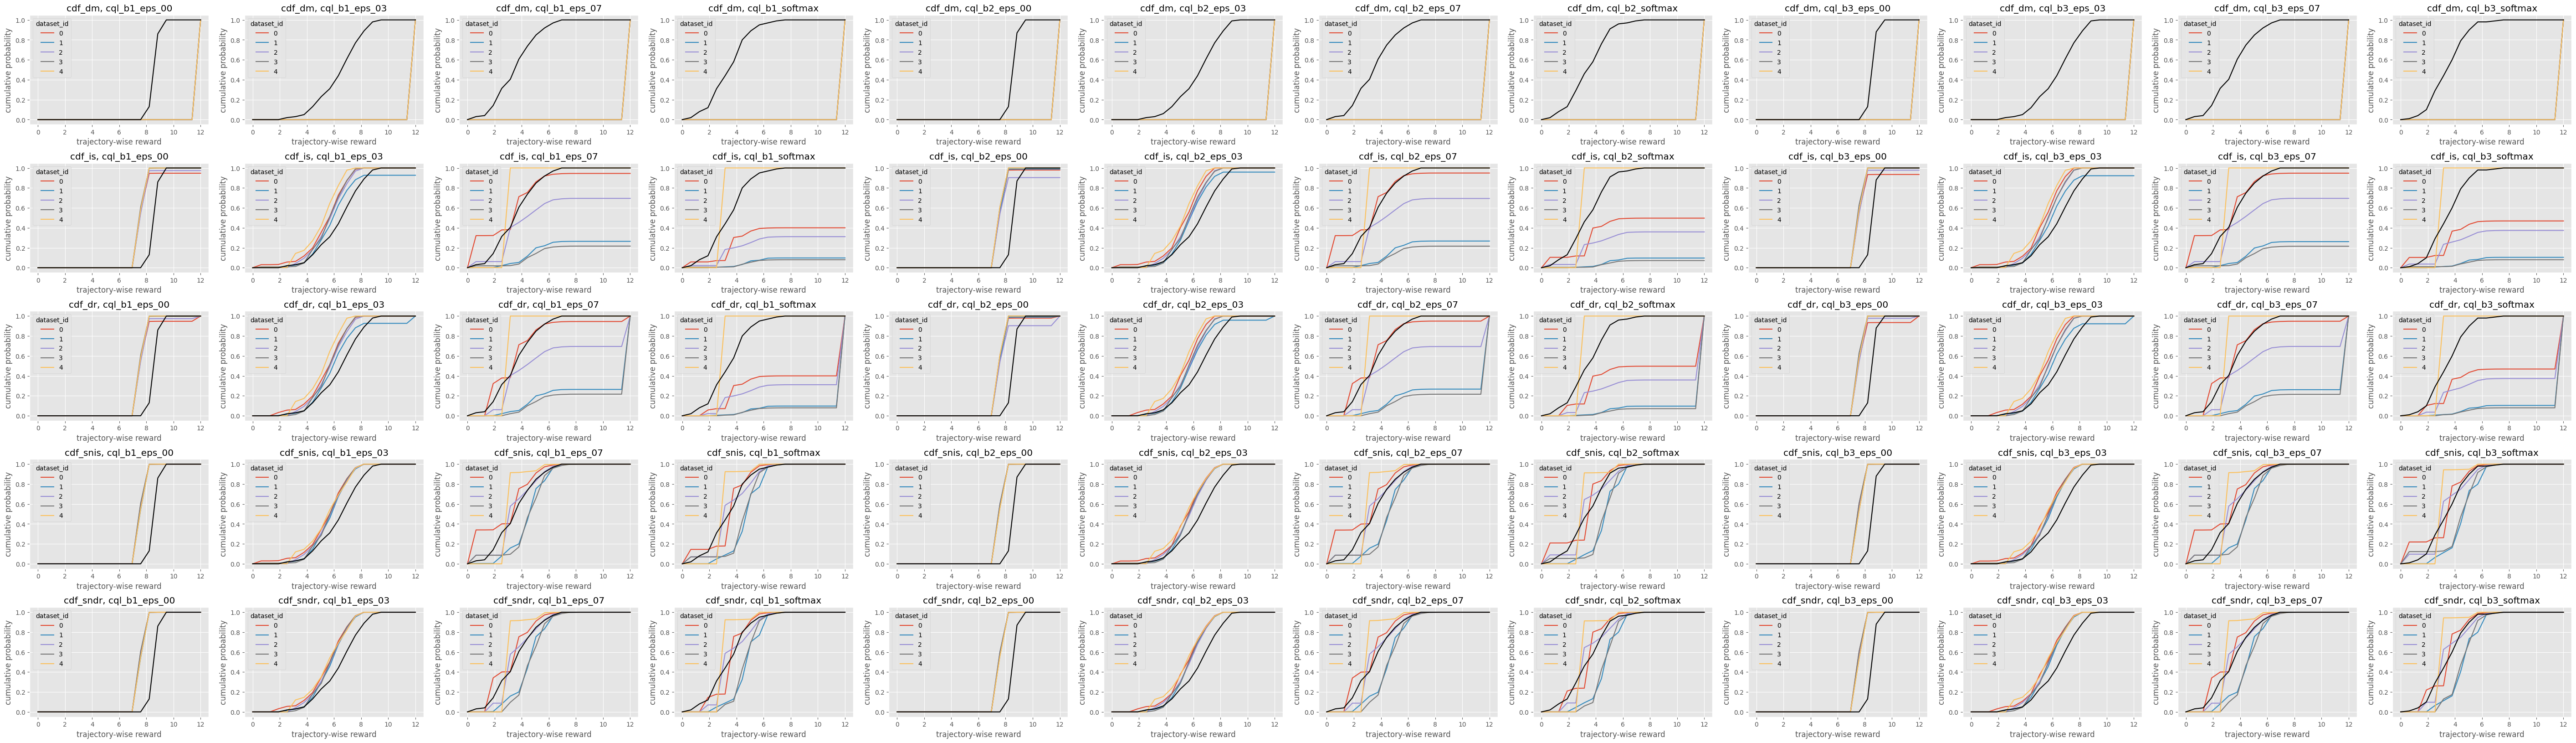

In [44]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
)

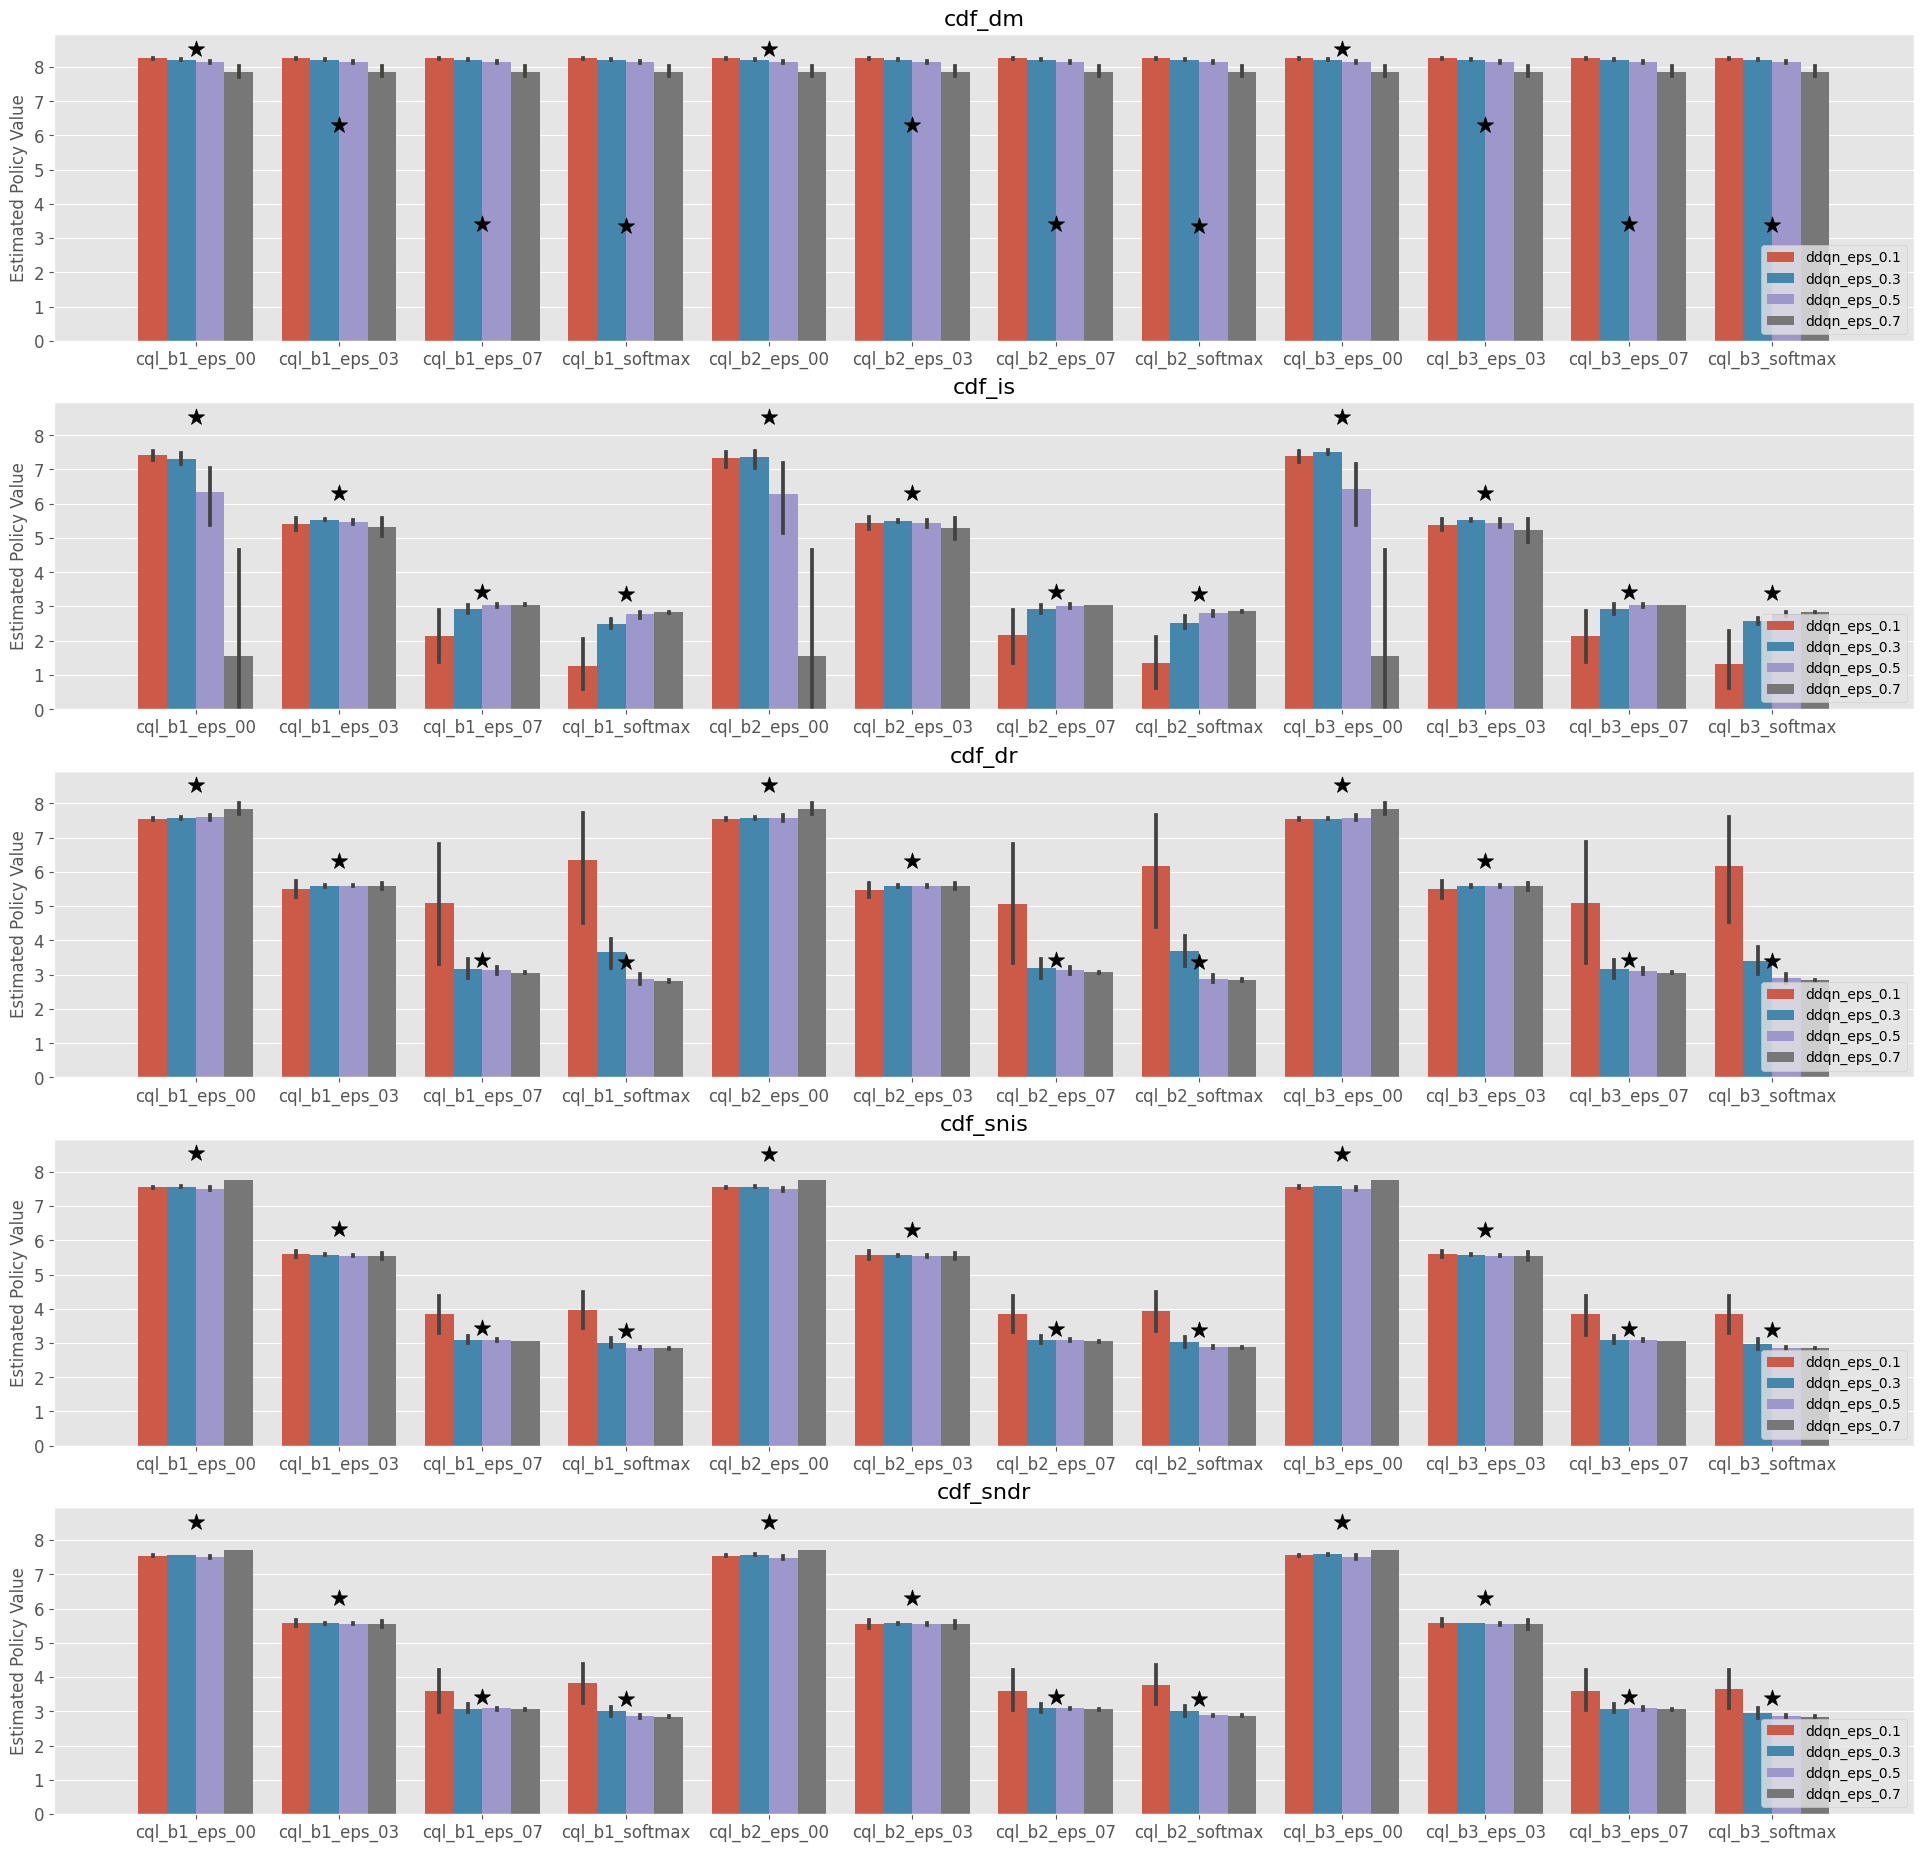

In [45]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

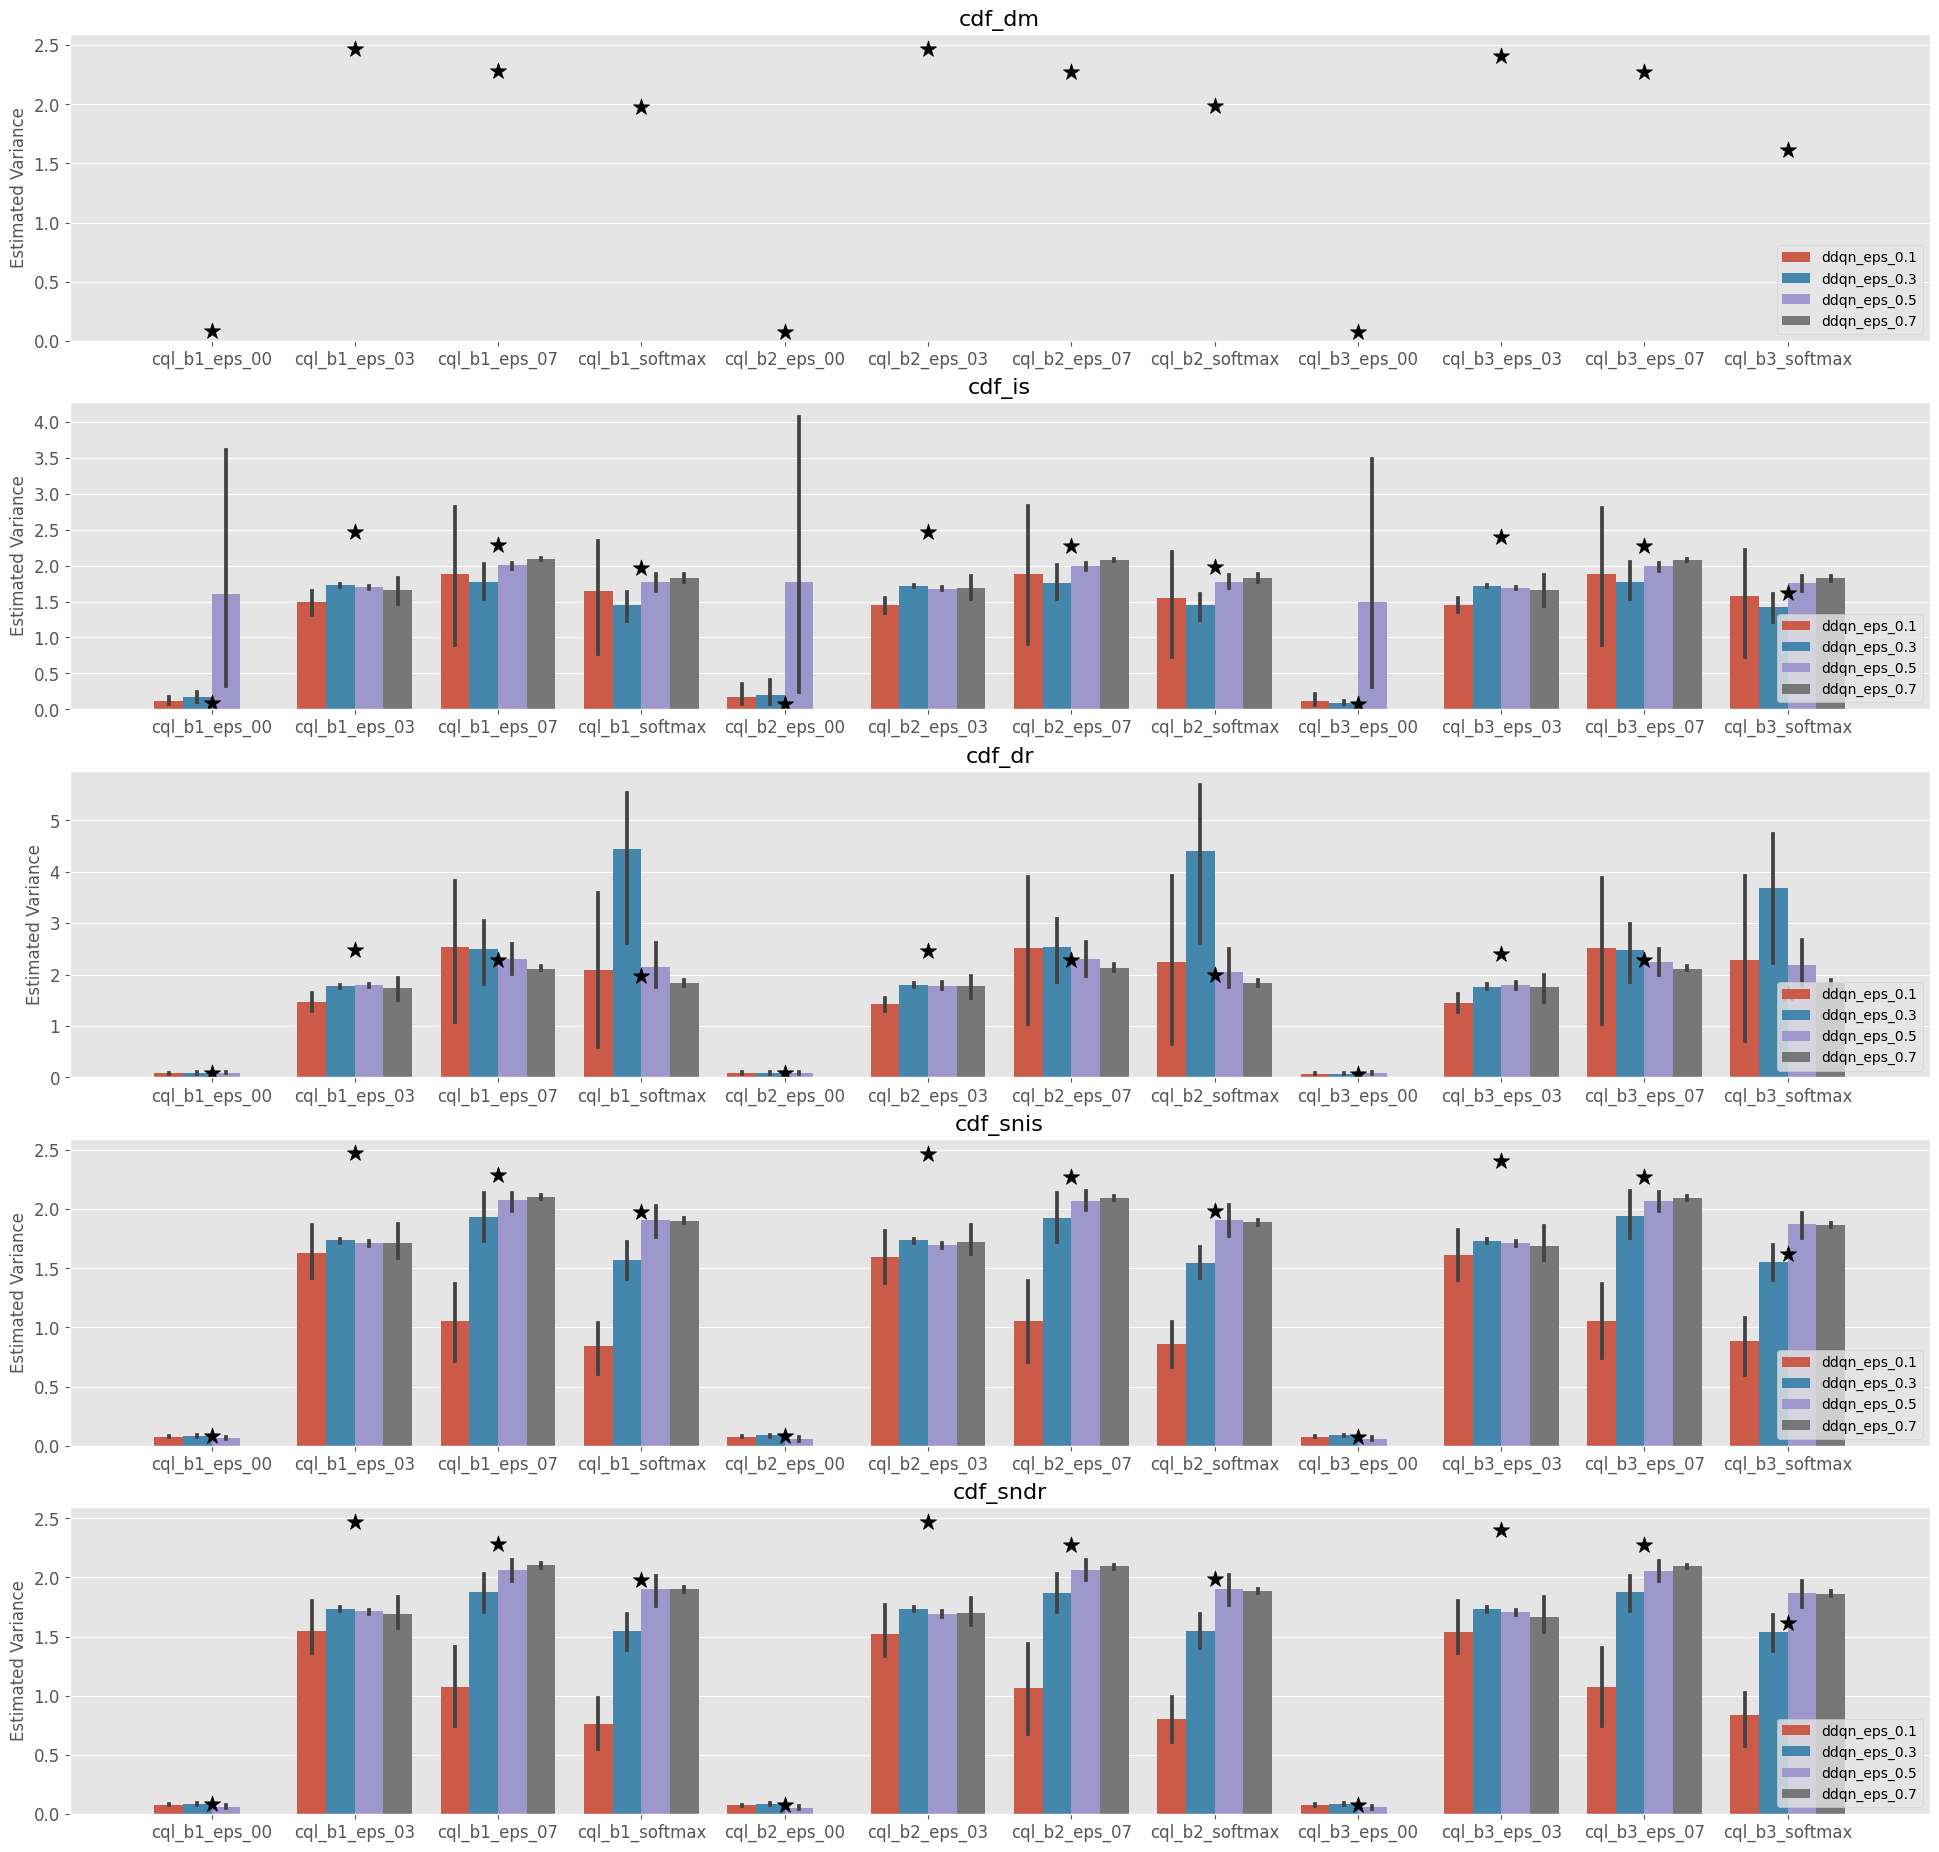

In [46]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

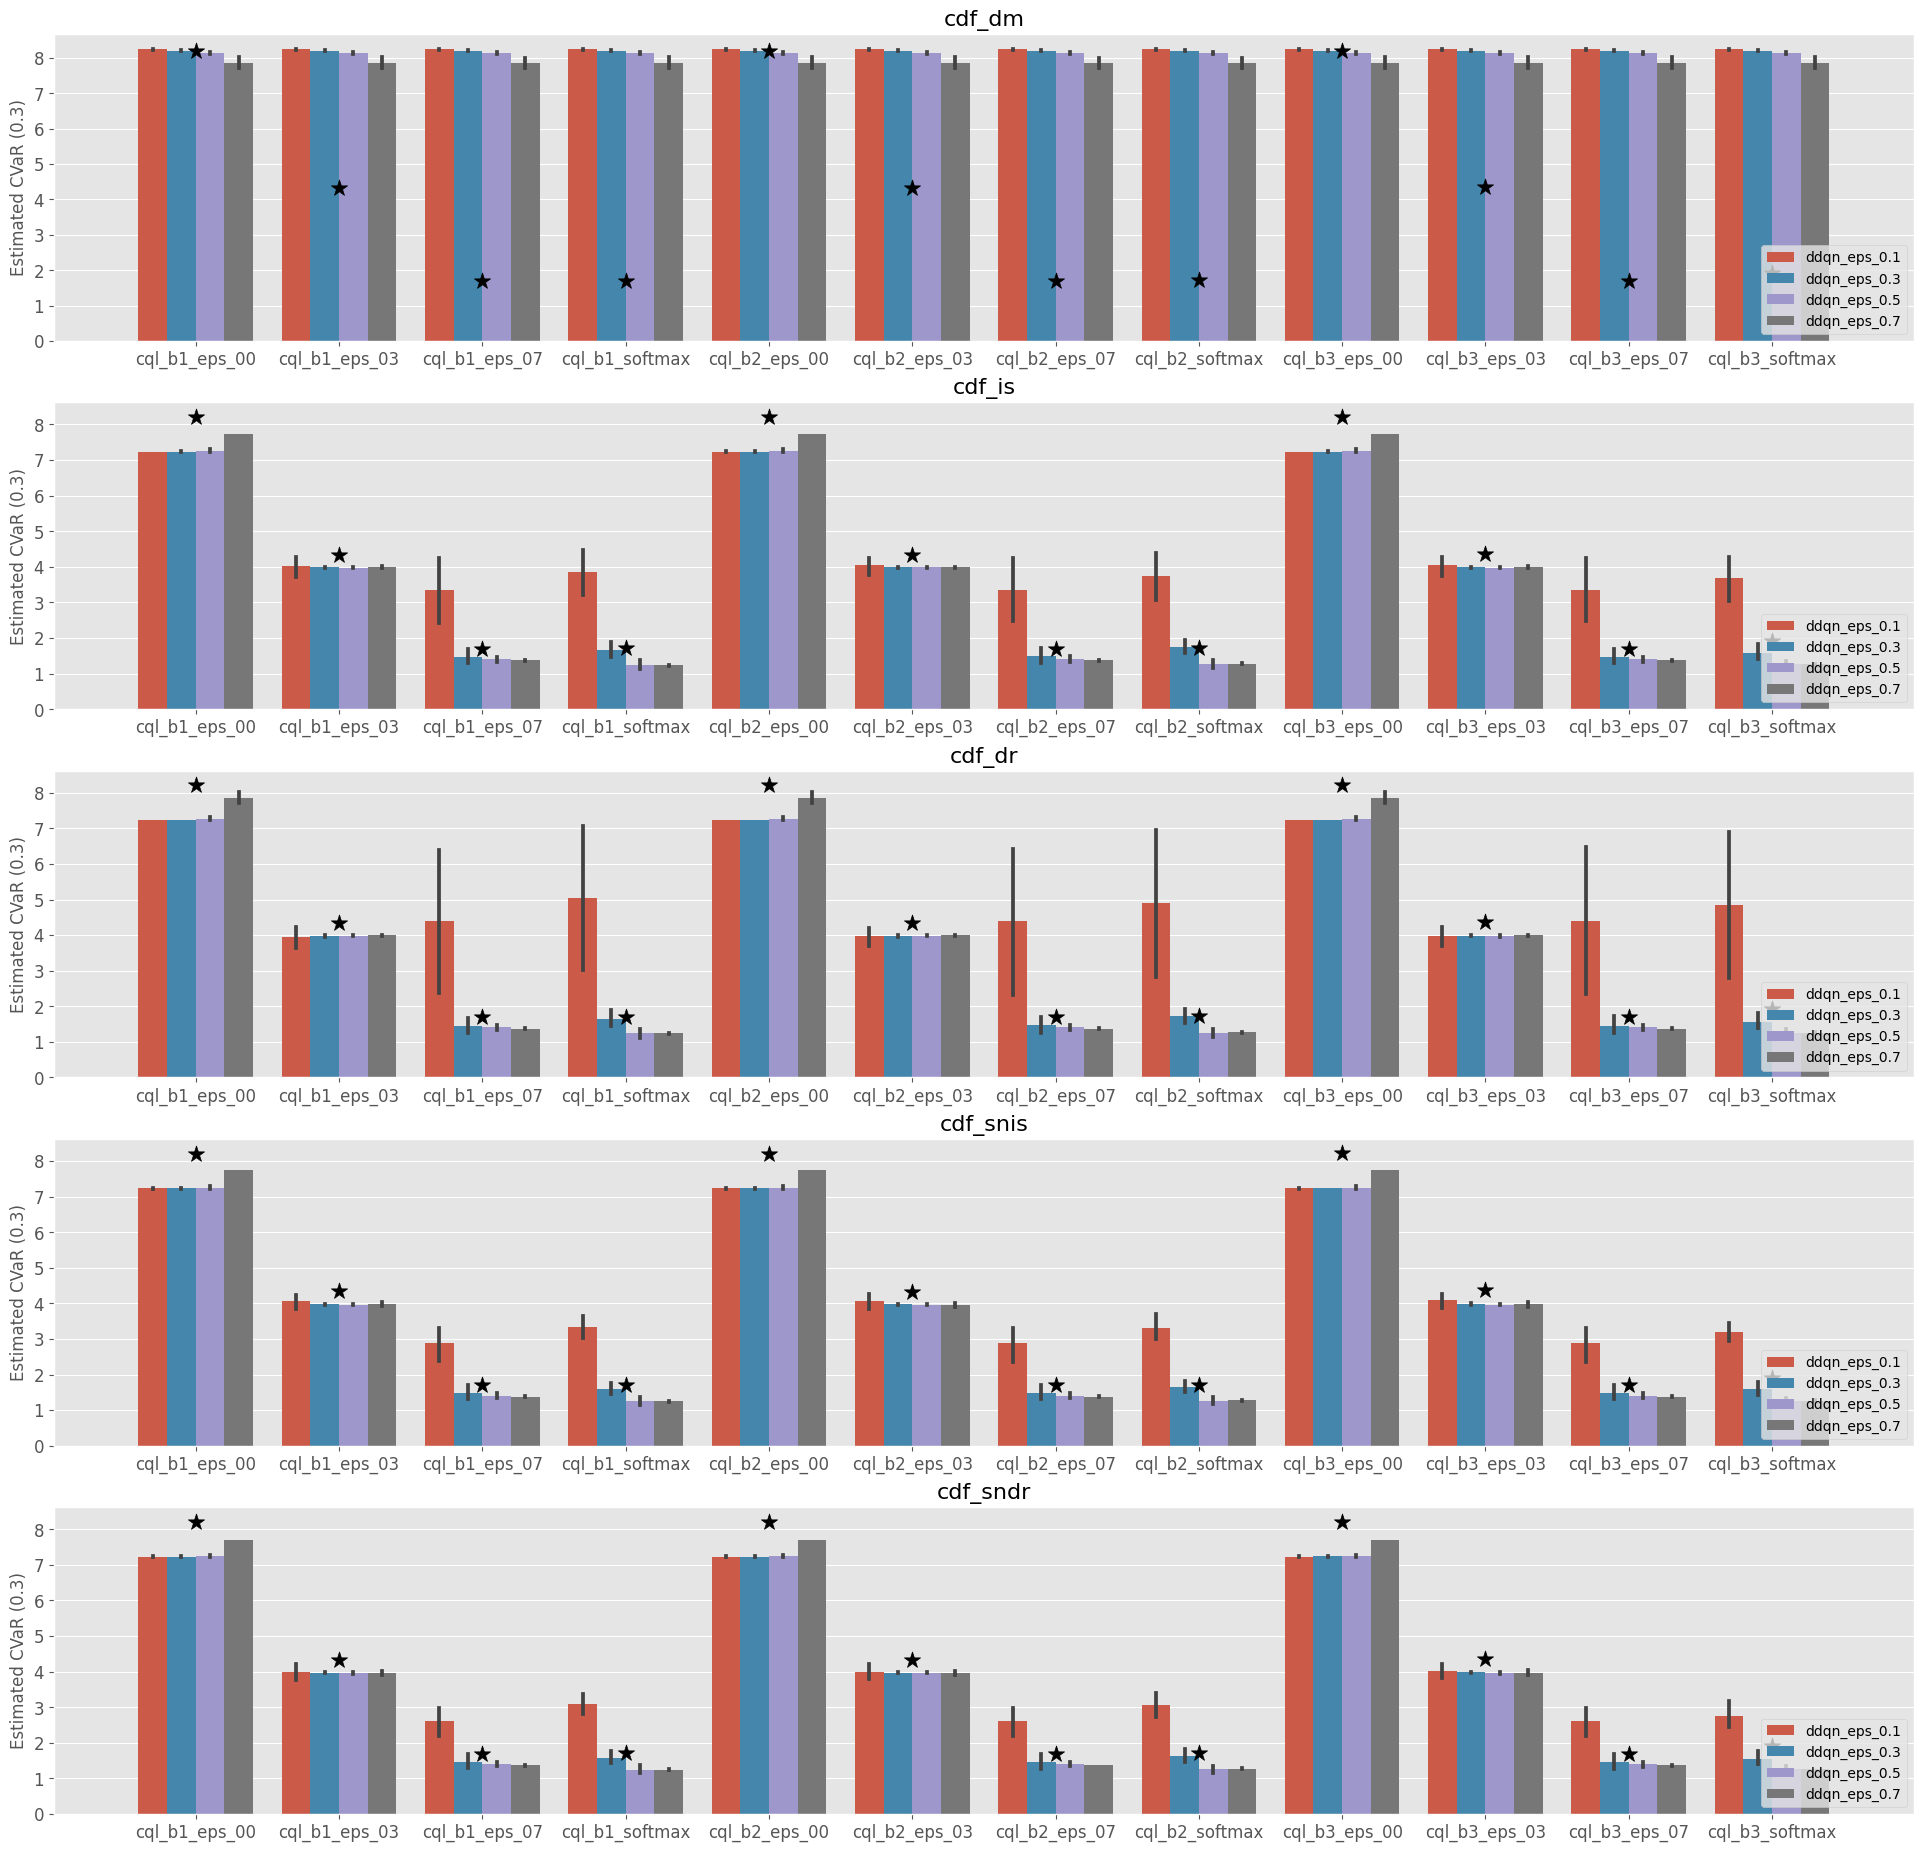

In [47]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

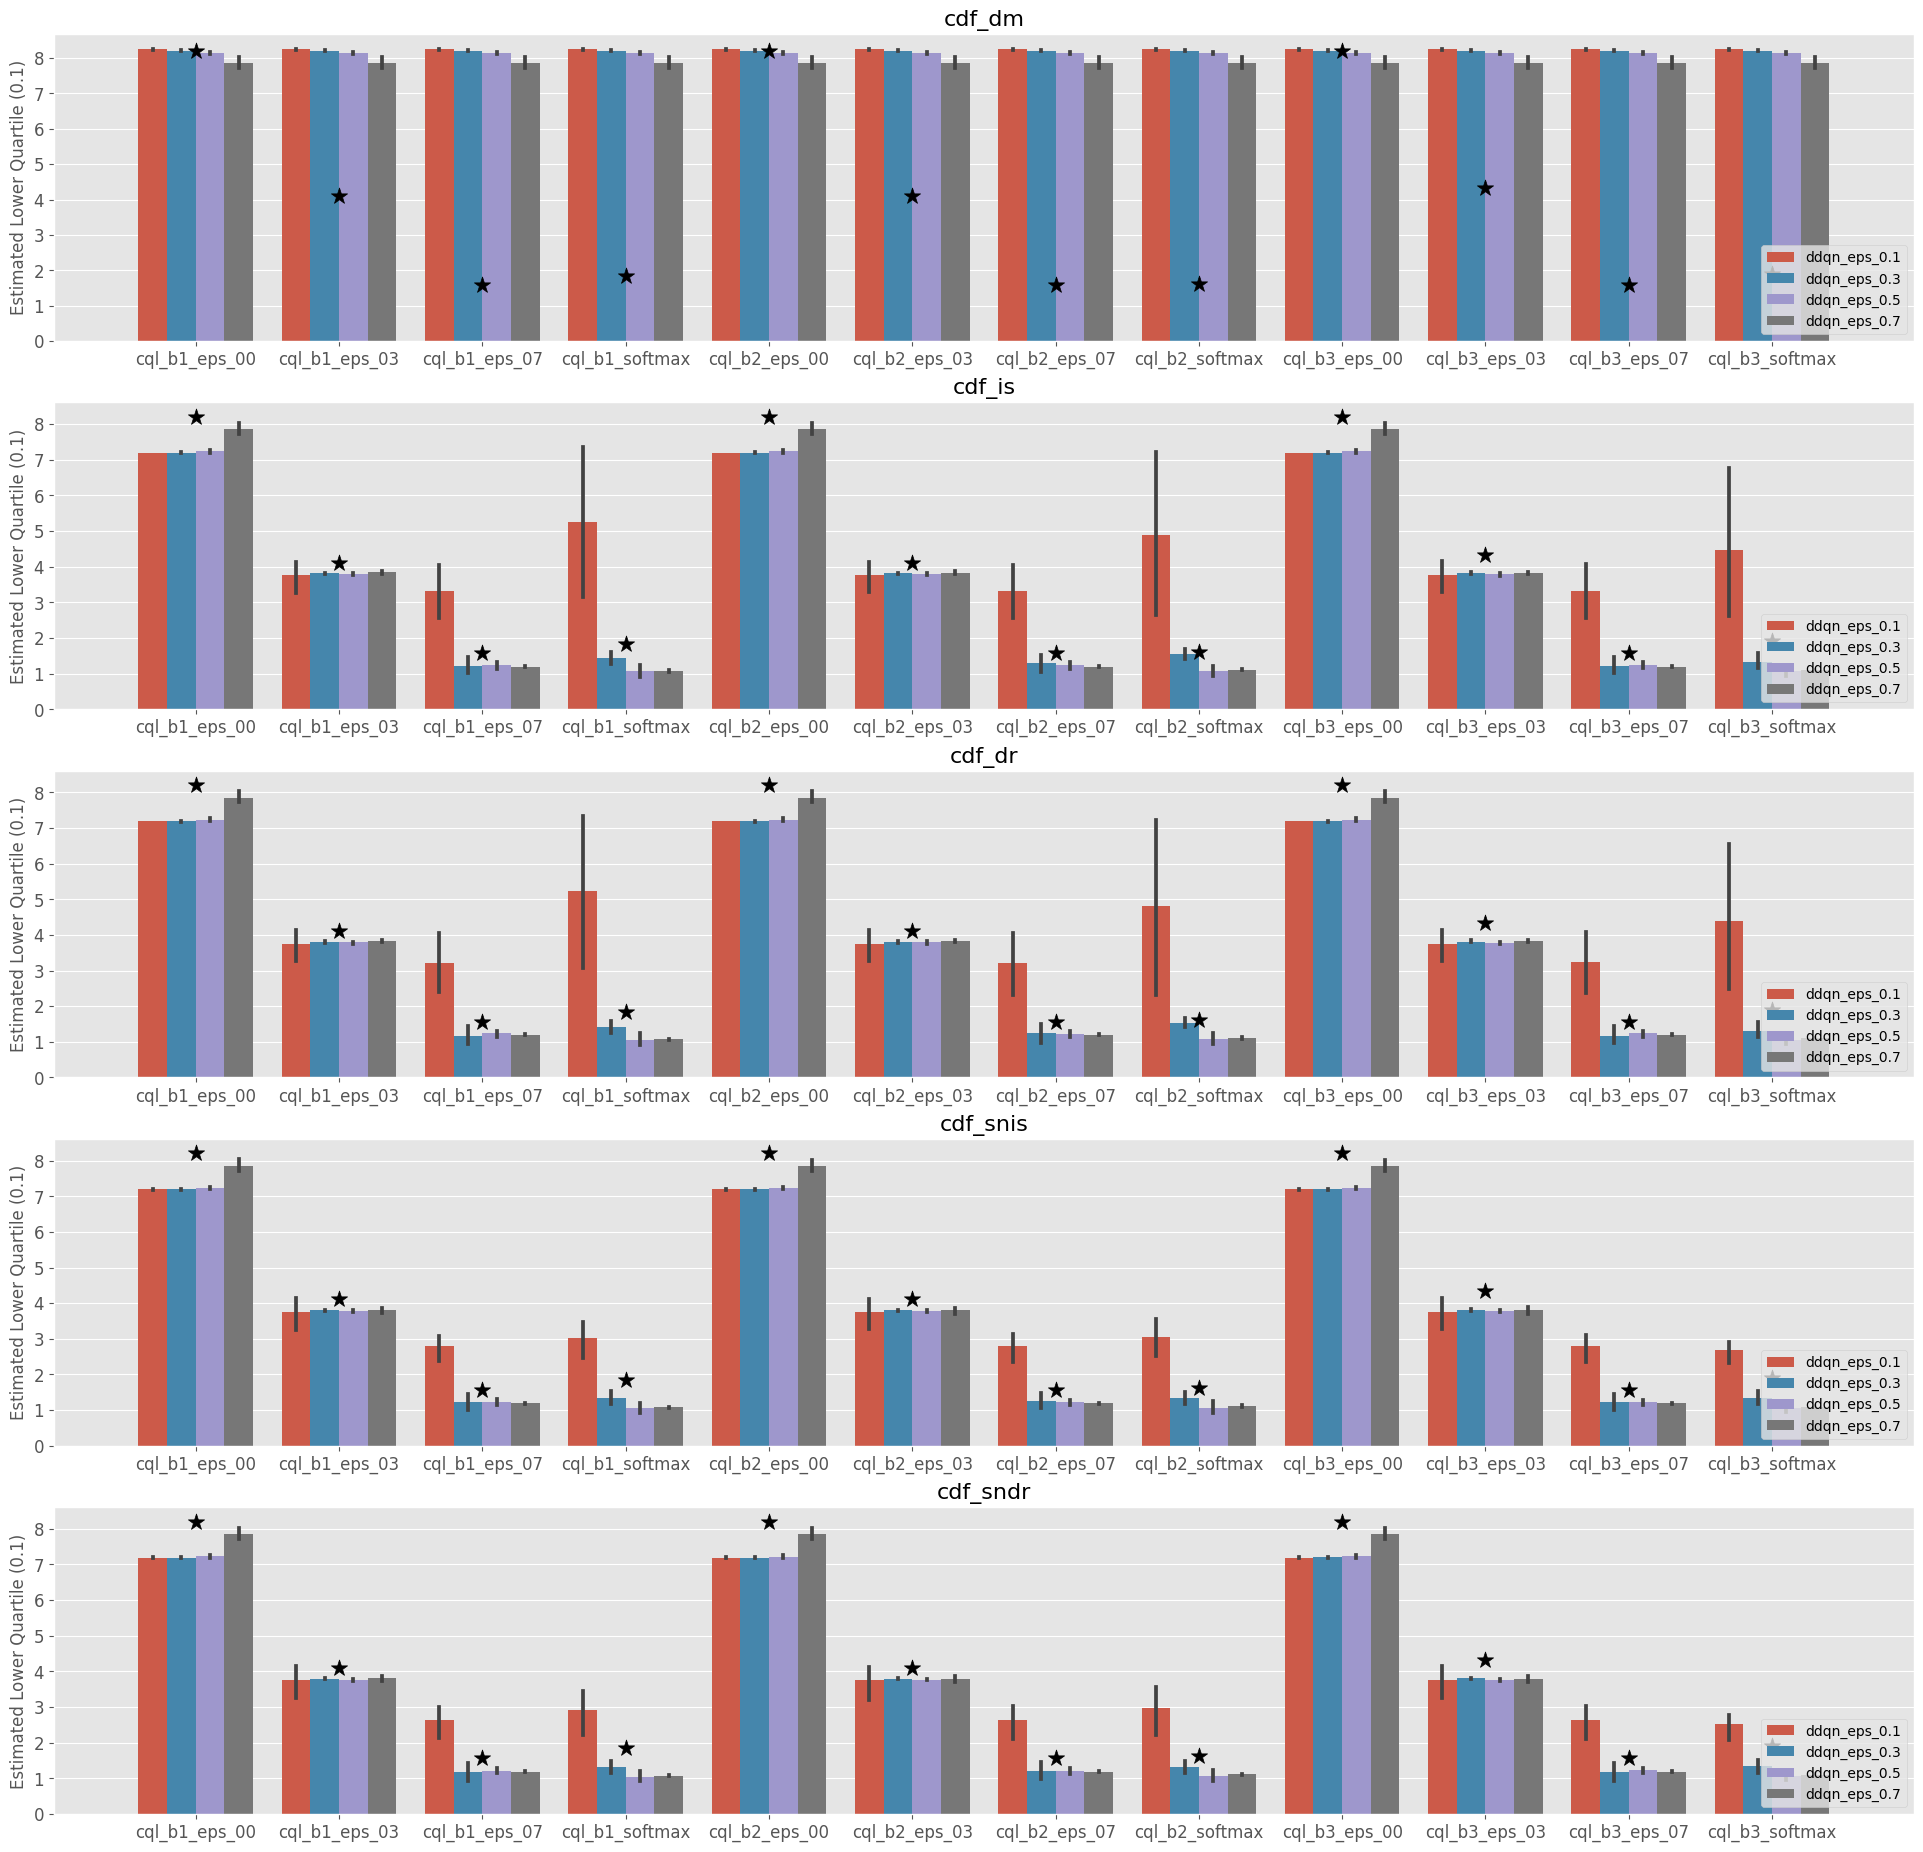

In [48]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.1,
    plot_type="ci",
    hue="policy",
)

## 3. オフ方策選択

オフ方策選択の目的は，これまで推定してきた方策の性能指標に基づき，いくつかの候補方策の中から最も性能の良い方策を選択することです．これは，実際にどの方策を実環境にデプロイするか決定する手順に相当します．

In [49]:
from scope_rl.ope import OffPolicySelection

In [50]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [51]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result["ddqn_eps_0.1"][0]

ranking  policy_value  relative_policy_value  variance  \
0    cql_b1_eps_00      8.534607               1.238434  0.080646   
1    cql_b3_eps_00      8.529597               1.237707  0.076185   
2    cql_b2_eps_00      8.527118               1.237347  0.078065   
3    cql_b1_eps_03      6.314321               0.916254  2.470162   
4    cql_b3_eps_03      6.313976               0.916204  2.404197   
5    cql_b2_eps_03      6.309856               0.915606  2.466234   
6    cql_b1_eps_07      3.423805               0.496819  2.284297   
7    cql_b3_eps_07      3.417935               0.495967  2.274348   
8    cql_b2_eps_07      3.417935               0.495967  2.274348   
9   cql_b3_softmax      3.392982               0.492347  1.617500   
10  cql_b2_softmax      3.368461               0.488788  1.985820   
11  cql_b1_softmax      3.362528               0.487928  1.973618   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00        8.103080   
1              cql_b1_eps_03        8.103080   
2              cql_b1_eps_07        8.103080   
3             cql_b1_softmax        3.872159   
4              cql_b2_eps_00        3.807830   
5              cql_b2_eps_03        3.643320   
6              cql_b2_eps_07        1.607178   
7              cql_b3_eps_00        1.316717   
8             cql_b2_softmax        1.316717   
9              cql_b3_eps_03        1.316717   
10             cql_b3_eps_07        0.991515   
11            cql_b3_softmax        0.966217   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b3_eps_00                   8.040388  
1                         cql_b2_eps_00                   8.040388  
2                         cql_b1_eps_00                   8.040388  
3                         cql_b3_eps_03                   2.779234  
4                         cql_b2_eps_03                   2.779234  
5                         cql_b1_eps_03                   2.779234  
6                        cql_b3_softmax                   1.035457  
7                        cql_b1_softmax                   0.723881  
8                        cql_b2_softmax                   0.684661  
9                         cql_b3_eps_07                   0.379464  
10                        cql_b2_eps_07                   0.379464  
11                        cql_b1_eps_07                   0.379464

In [52]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [53]:
ranking_df["ddqn_eps_0.1"][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b1_eps_00               88.627433                        12.860492   
 1      cql_b3_eps_03               84.728752                        12.294765   
 2      cql_b1_eps_03               83.546435                        12.123202   
 3      cql_b2_eps_07               81.238938                        11.788367   
 4      cql_b3_eps_07               80.931021                        11.743686   
 5      cql_b2_eps_00               80.660290                        11.704401   
 6     cql_b2_softmax               79.955351                        11.602109   
 7     cql_b3_softmax               79.796994                        11.579131   
 8      cql_b1_eps_07               79.077941                        11.474791   
 9      cql_b3_eps_00               78.748096                        11.426928   
 10     cql_b2_eps_03               78.434244                        11.381386   
 11    cql

In [54]:
metric_df["ddqn_eps_0.1"][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm         5690.005281          0.419580  0.174519  0.000000   
1       tis            1.380501          0.923077  0.000019  0.007490   
2      pdis            0.675021          0.937063  0.000007  0.007490   
3        dr          440.583556         -0.384615  0.217020  5.172079   
4     sntis            0.450326          0.734266  0.006543  0.007490   
5    snpdis            0.422863          0.769231  0.003446  0.005010   
6      sndr            1.785887          0.937063  0.000007  0.000000   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           0.083333                 0.0  
4           0.000000                 0.0  
5           0.000000                 0.0  
6           0.000000                 0.0

In [55]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=14.0,
    return_by_dataframe=True,
)

In [56]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  6.001659  6.001659  6.001659  6.001659       NaN   
1         dm     1  5.815132  7.031629  4.785162  5.908396  1.588492   
2         dm     2  4.564019  7.610801  3.683139  5.460270  2.185476   
3         dm     3  5.337085  7.866894  3.387907  5.429474  2.159117   
4         dm     4  4.784684  7.977909  3.381140  5.300516  2.097384   
5         dm     5  4.606444  7.977909  3.375643  5.184837  2.082956   
6         dm     6  5.259791  8.199937  3.371053  5.195545  2.146504   
7         dm     7  5.663404  8.310701  3.366781  5.254027  2.164629   
8         dm     8  5.667006  8.422090  3.365237  5.299914  2.193974   
9         dm     9  6.211232  8.533355  3.364940  5.391046  2.216754   
10        dm    10  5.995315  8.534357  3.363121  5.445979  2.257586   
11        dm    11  5.007347  8.534607  3.362528  5.409427  2.255623   
0        tis     0  7.718558  7.718558  7.718558  7.718558       NaN   
1        tis     1  7.717793  7.720450  7.715901  7.718176  0.003217   
2        tis     2  7.718311  7.722454  7.714573  7.718221  0.004099   
3        tis     3  5.701898  7.835010  5.587597  7.214140  1.121882   
4        tis     4  5.699597  7.835010  5.585135  6.911231  1.229237   
5        tis     5  5.699696  7.835010  5.584105  6.709309  1.229263   
6        tis     6  3.663426  8.090175  3.405196  6.274183  1.814645   
7        tis     7  3.661427  8.090299  3.401313  5.947588  2.009710   
8        tis     8  3.667478  8.090550  3.401313  5.694243  2.085451   
9        tis     9  4.557514  8.533605  3.373741  5.580570  2.199365   
10       tis    10  4.551243  8.533605  3.363714  5.486995  2.244529   
11       tis    11  4.556177  8.534607  3.362528  5.409427  2.255623   
0       pdis     0  8.160735  8.160735  8.160735  8.160735       NaN   
1       pdis     1  8.163019  8.164284  8.159471  8.161877  0.003403   
2       pdis     2  8.161542  8.166512  8.158025  8.161765  0.004365   
3       pdis     3  6.279332  8.279067  6.165030  7.691157  1.054938   
4       pdis     4  6.279269  8.279067  6.164137  7.408779  1.155290   
5       pdis     5  6.278286  8.279067  6.162489  7.220364  1.155310   

    safety_violation_rate  sharpe_ratio  
0                     1.0           NaN  
1                     1.0    205.206822  
2                     1.0      1.687155  
3                     1.0      1.341843  
4                     1.0      1.432680  
5                     1.0      1.459809  
6                     1.0      1.533099  
7                     1.0      1.562491  
8                     1.0      1.570361  
9                     1.0      1.610718  
10                    1.0      1.583963  
11                    1.0      1.589264  
0                     1.0           NaN  
1                     1.0   2499.225762  
2                     1.0    878.465433  
3                     1.0      2.621536  
4                     1.0      2.392585  
5                     1.0      2.392585  
6                     1.0      1.744817  
7                     1.0      1.602555  
8                     1.0      1.563113  
9                     1.0      1.673045  
10                    1.0      1.610122  
11                    1.0      1.589264  
0                     1.0           NaN  
1                     1.0   1709.224859  
2                     1.0    911.828180  
3                     1.0      3.158148  
4                     1.0      2.883549  
5                     1.0      2.883528

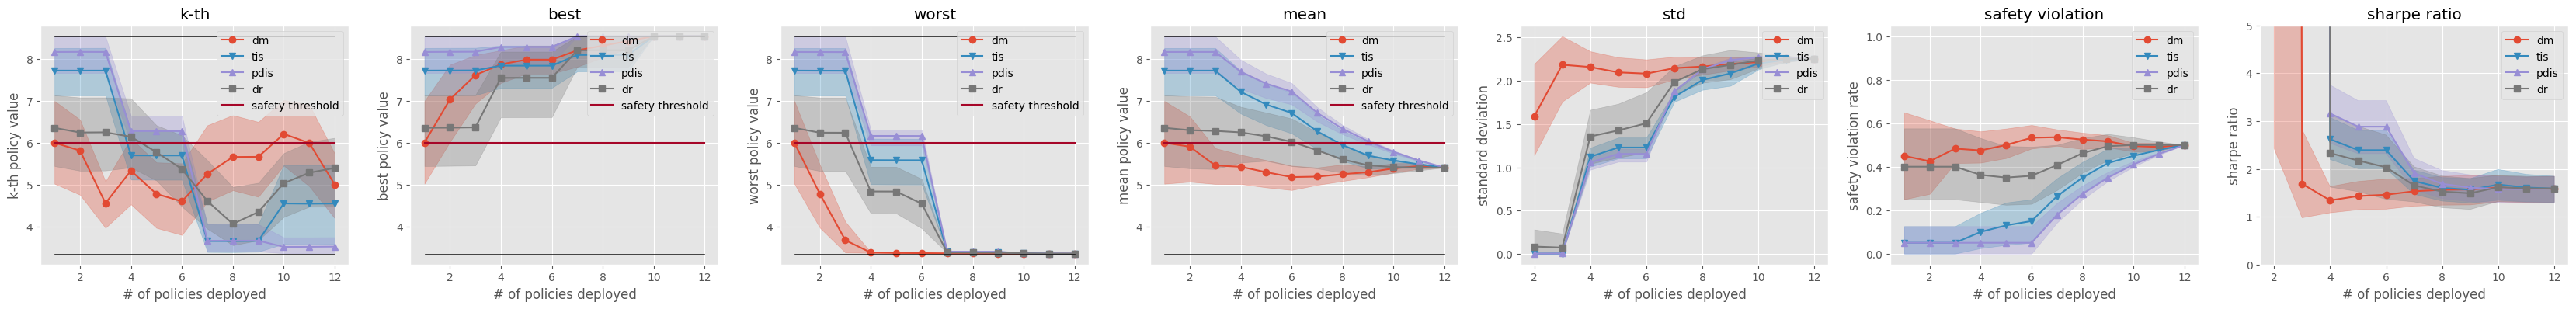

In [57]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_threshold=6.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

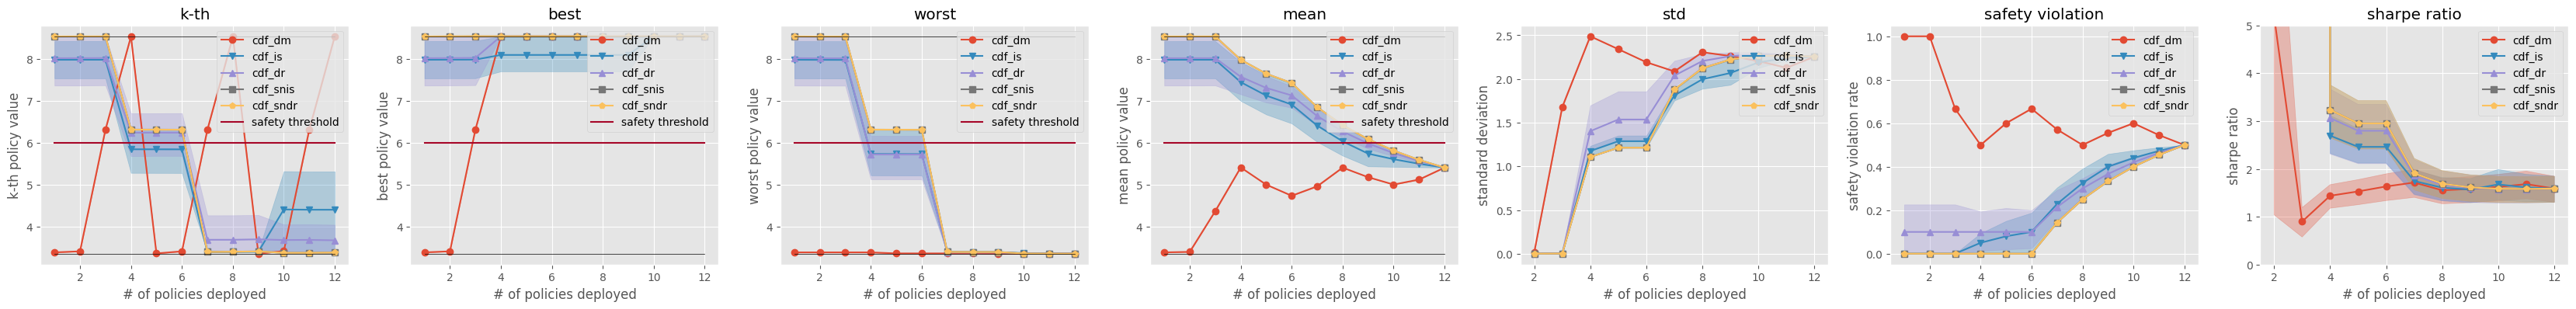

In [58]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=6.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

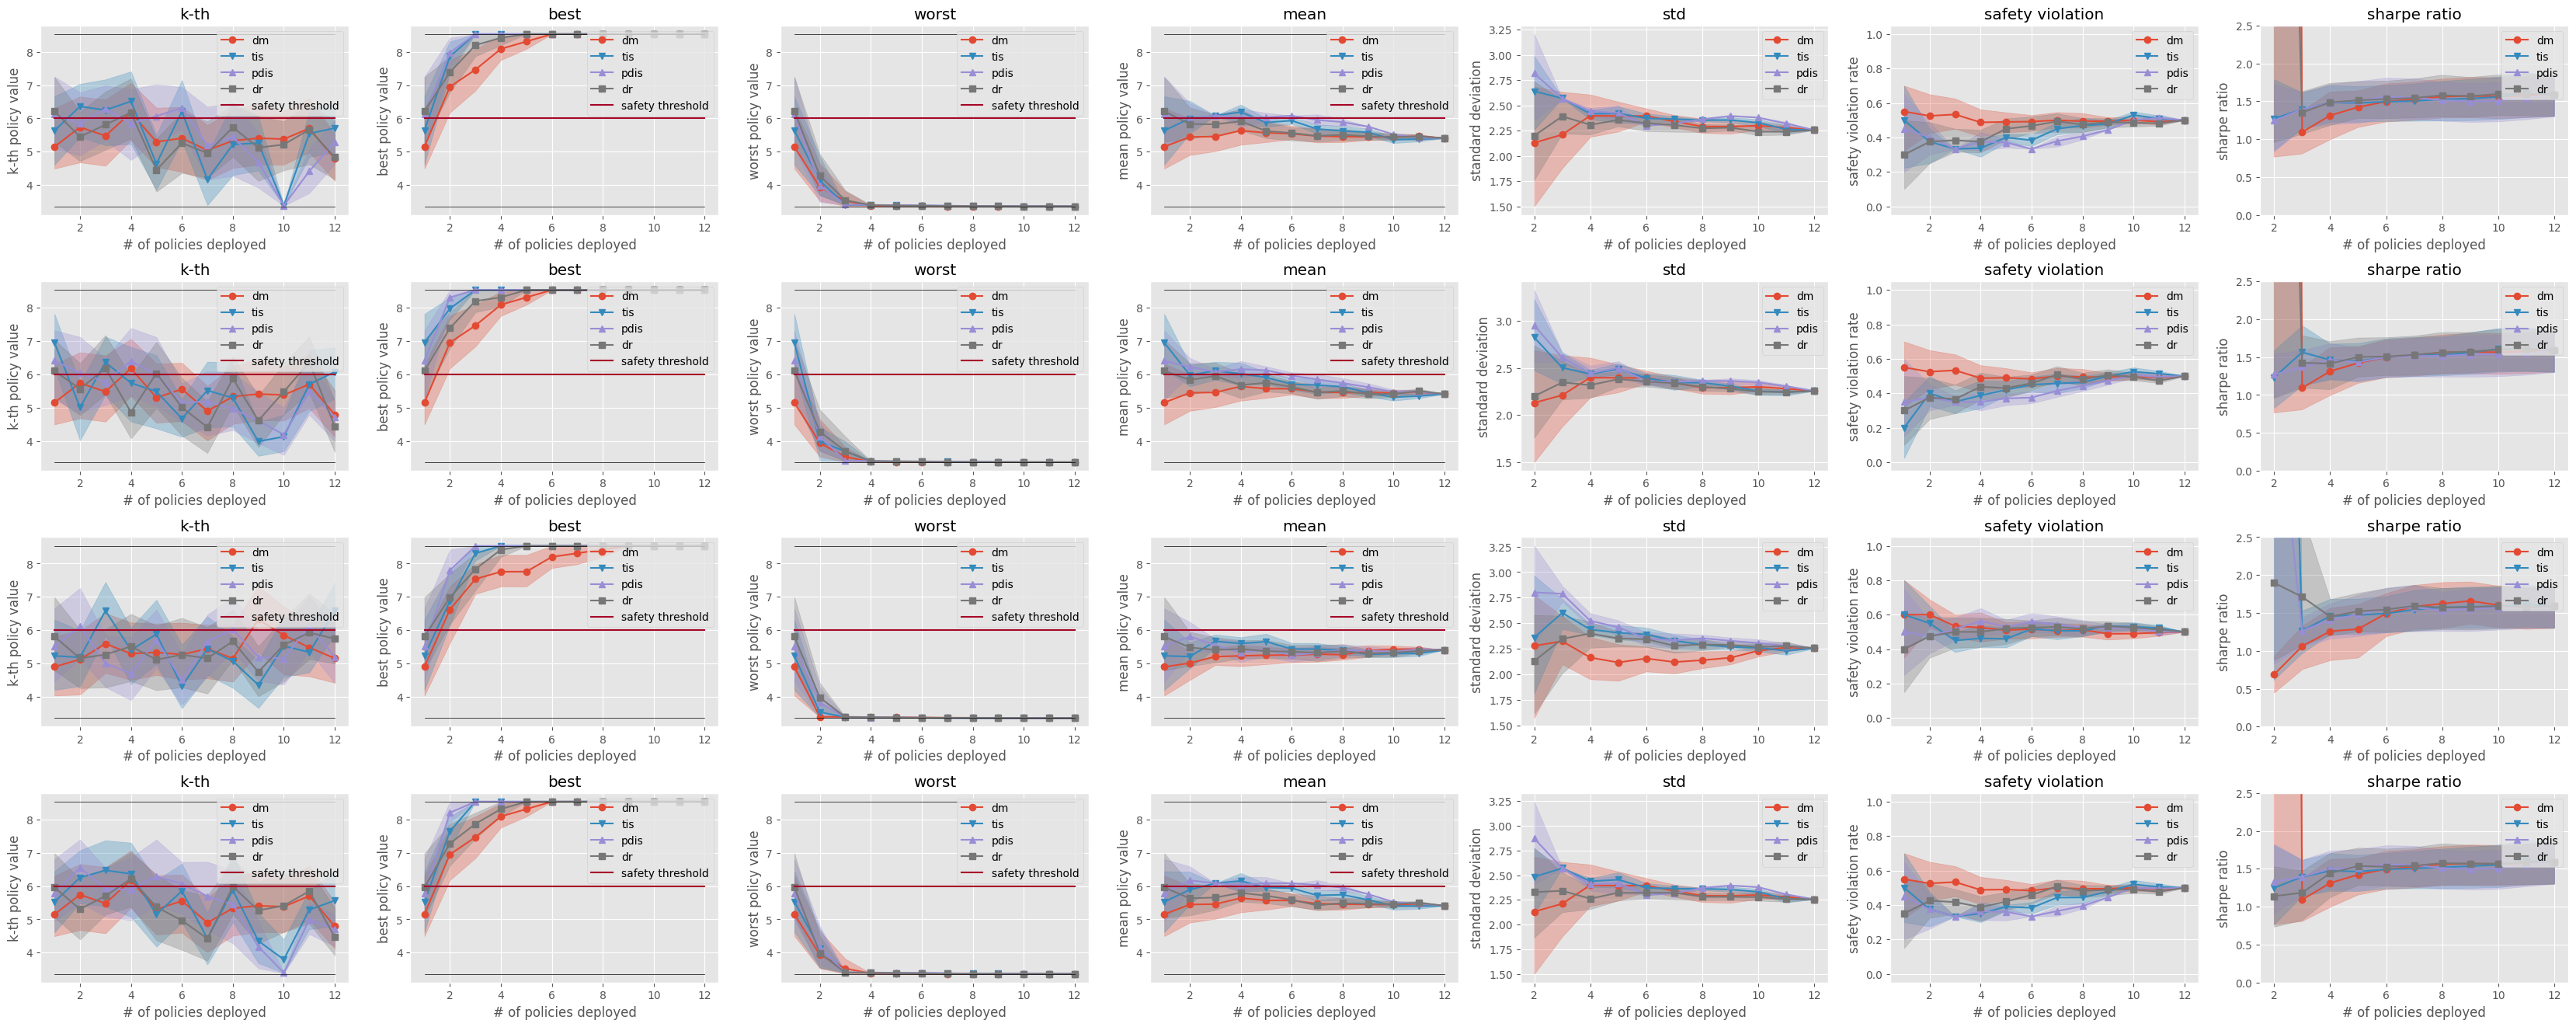

In [59]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=6.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

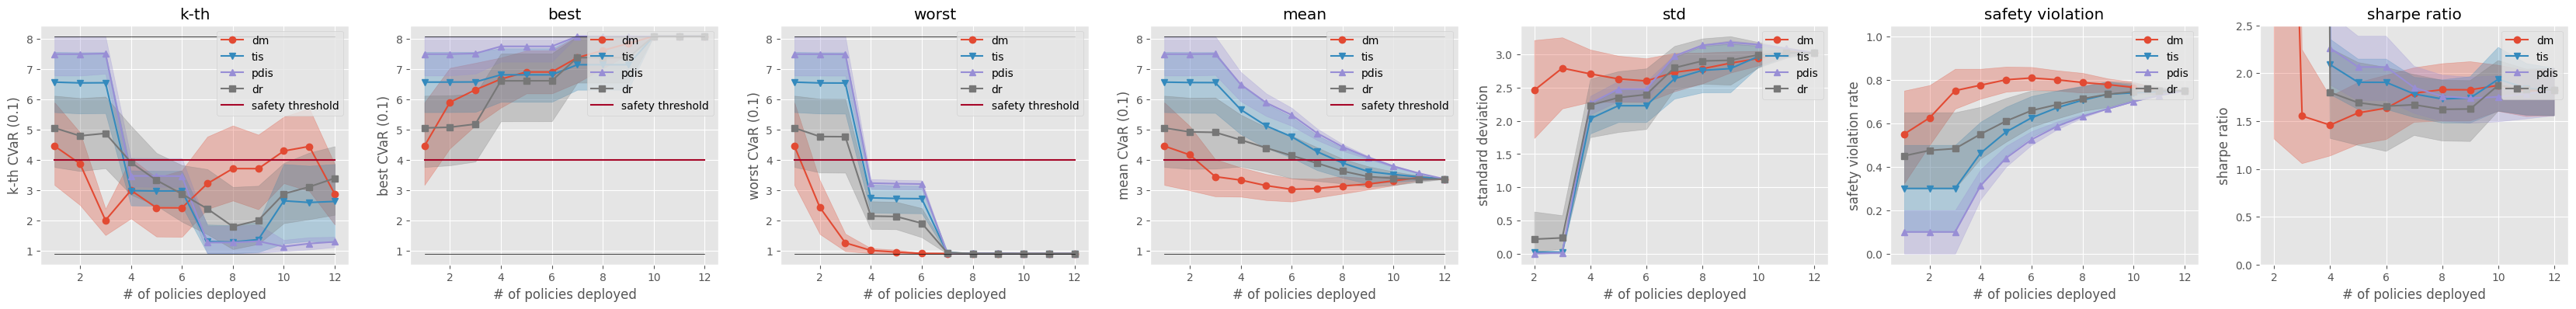

In [60]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

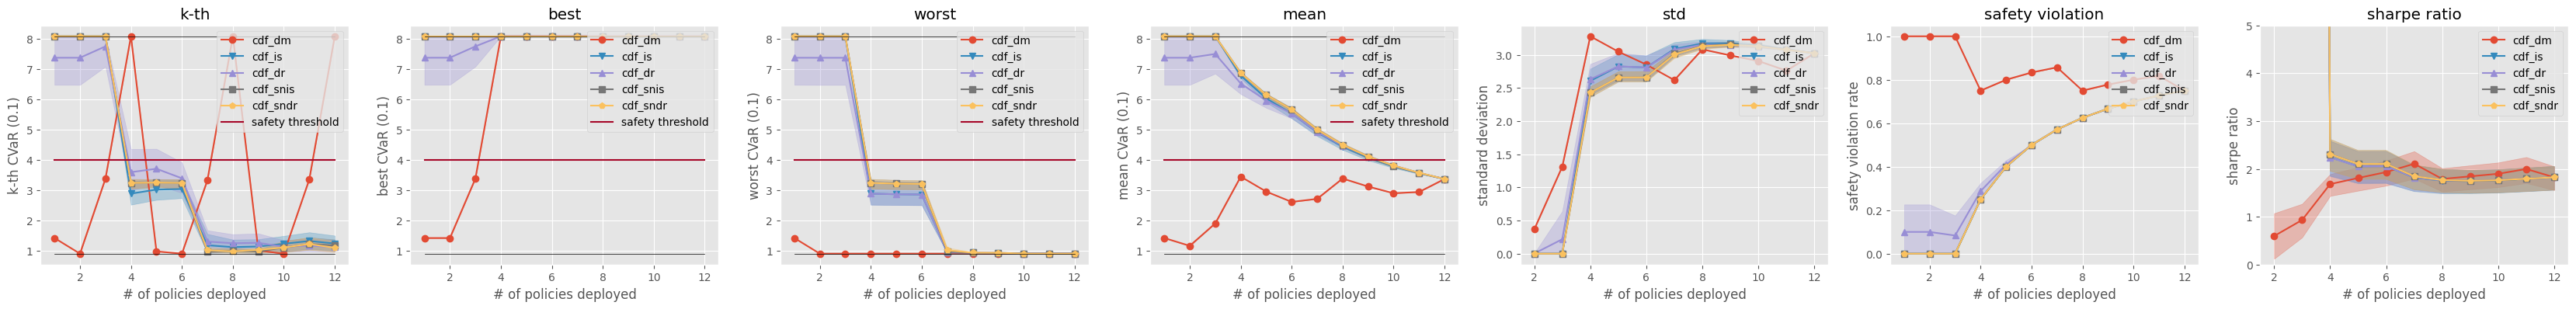

In [69]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

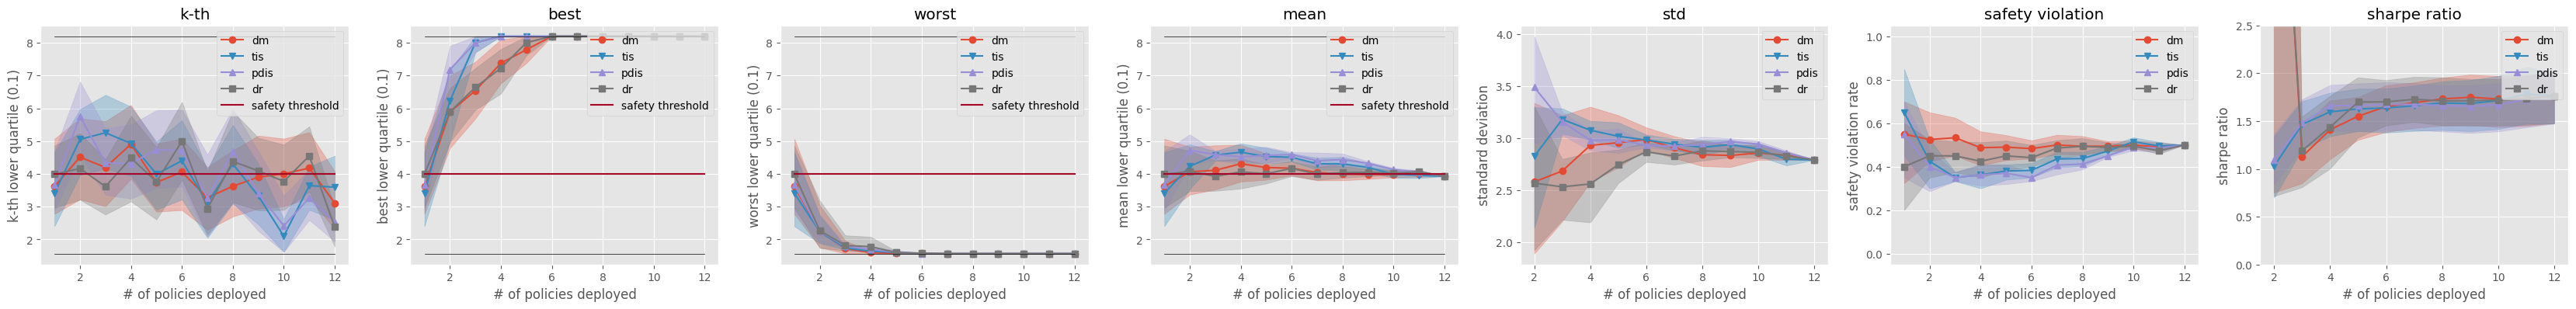

In [70]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

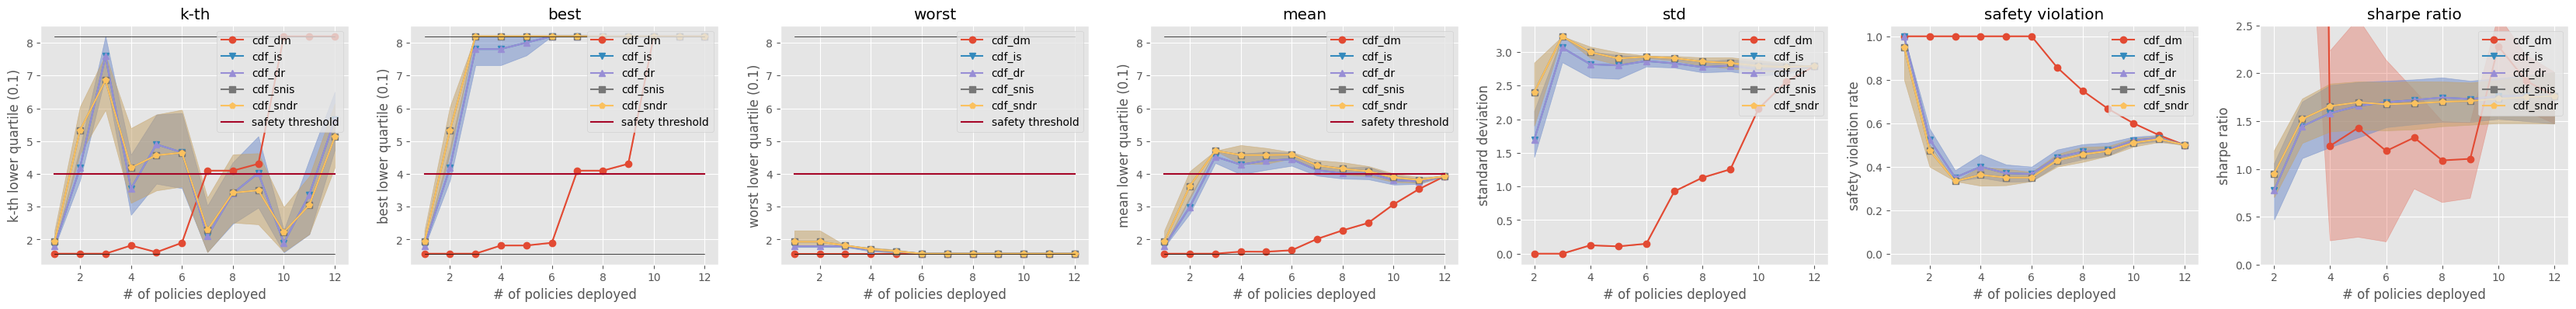

In [71]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

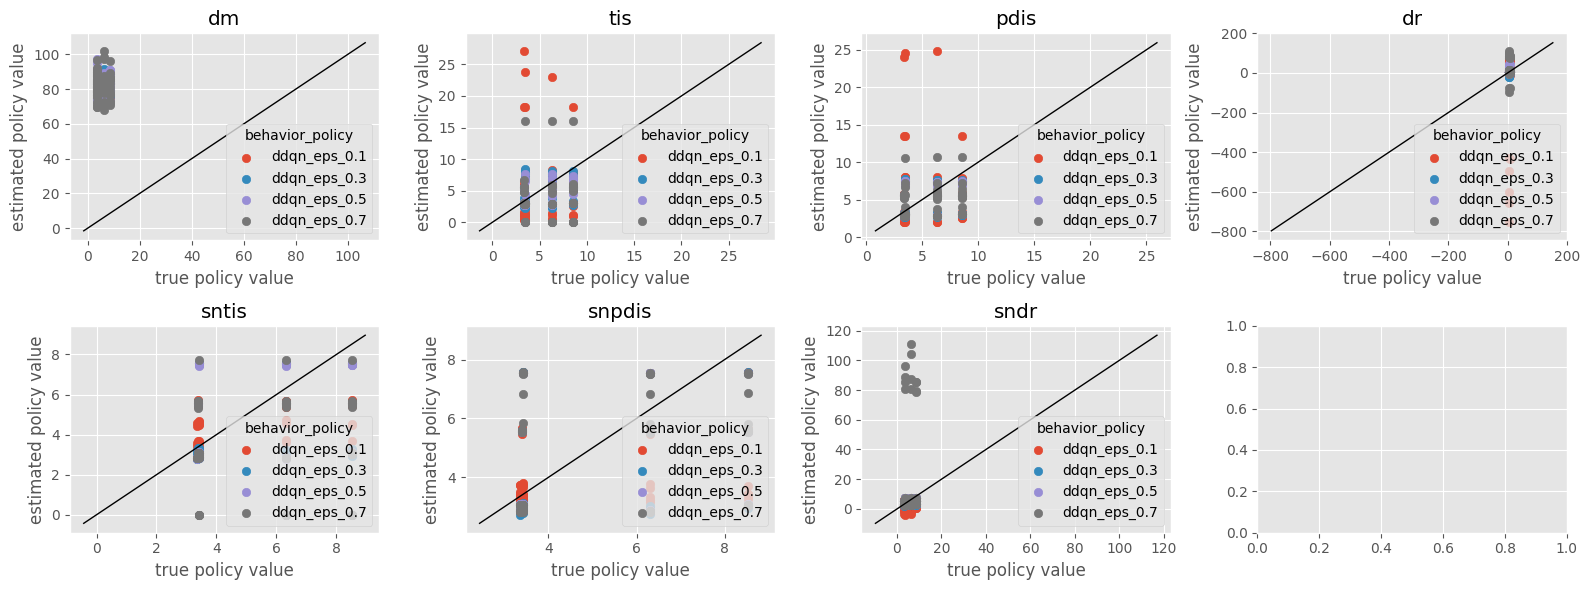

In [64]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
)

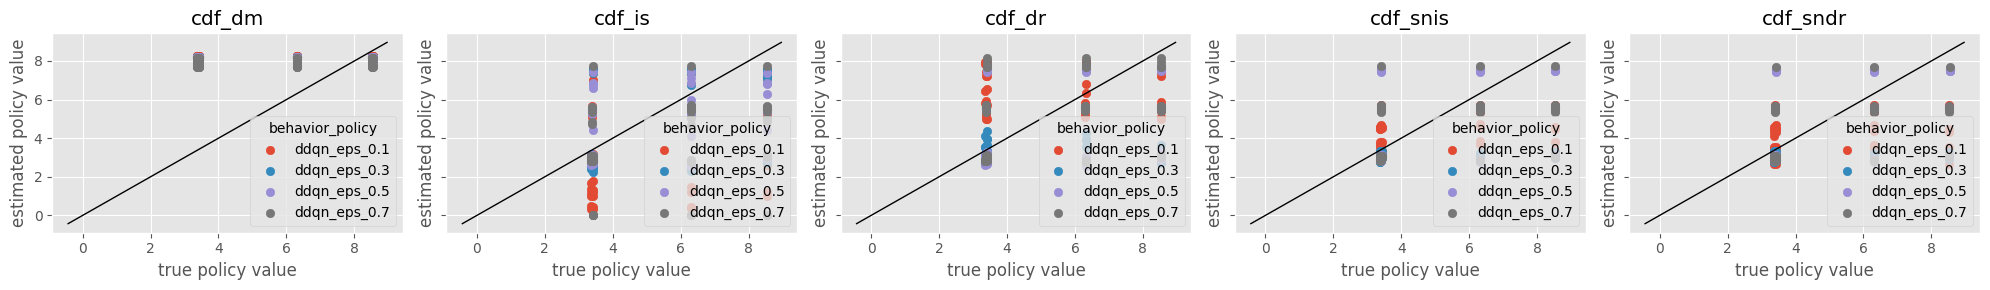

In [65]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

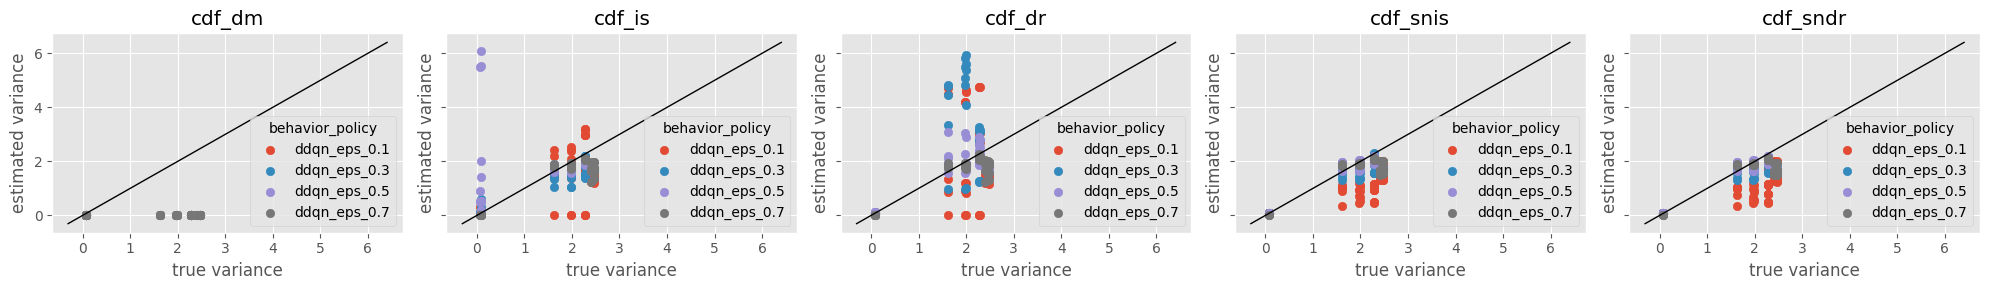

In [66]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

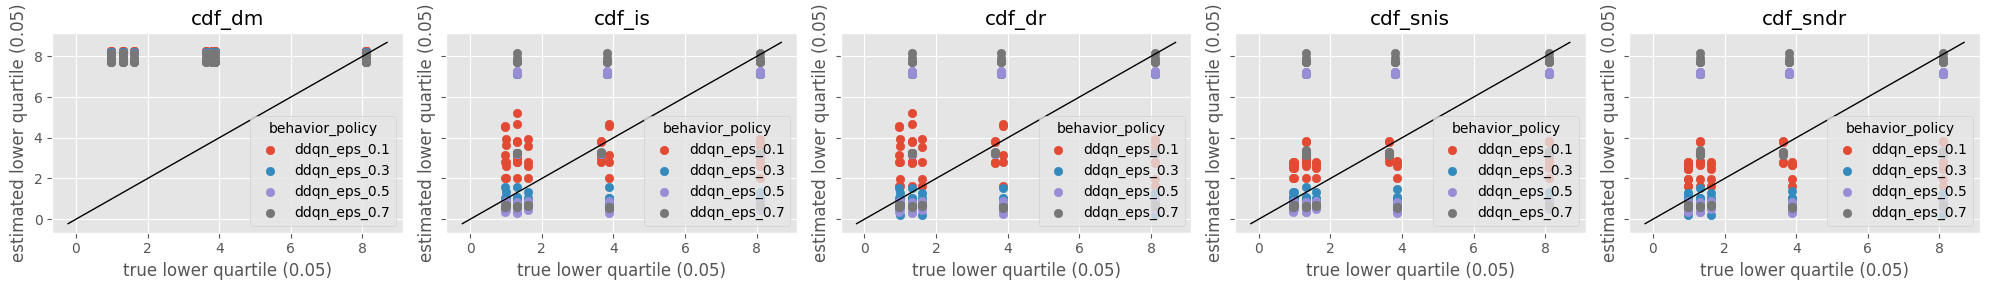

In [67]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

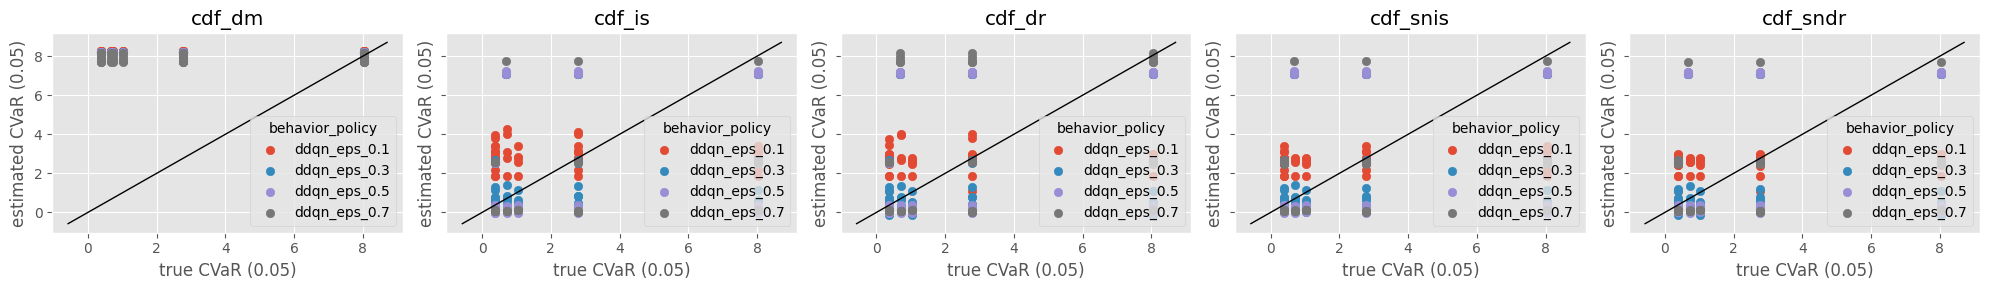

In [68]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

連続的な行動空間に対する例は，以下を参照してください． [examples/quickstart/basic/basic_synthetic_continuous_multiple_datasets_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_multiple_datasets_ja.ipynb).

## 参考文献

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.